<div style="text-align: center;" class="markdown-google-sans">
  <h1><font size=6>Assignment 1</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

In this project we are aiming to build an accurate model to predict daily bicycle rental demand using the provided bike sharing dataset. By analyzing the data and testing different modeling techniques, we will develop a robust model optimized to forecast the rental count metric on a held-out test set.<br>
The goal is to create a reliable demand prediction model for bike sharing operations.
</div>




*   כדאי להשתמש במודלים מבוססי עצים: xgboost, random forest
*   להעלות את המחברת לגיט האב ולשים את הקישור בתיבת הגשה וגם את הסי-אס-וי








<div style="text-align: center;" class="markdown-google-sans">
  <h1><font size=5>Data - Yuval Hagever</font></h1>
</div>

`train.csv` and `test.csv` - contain information on bike rentals, including the timestamp, seasonal indicators, holiday and working day flags, weather conditions, temperature metrics, humidity, windspeed, pollution, sunlight, traffic, and the count of bikes rented at each recorded time.<br>
Target variable to predict is "count" (Label).<br><br>


למחוק לפני הגשה:<br>

---


<u>datetime</u> - time of rental<br>
<u>season</u> - (1:winter, 2:spring, 3:summer, 4:fall)<br>
<u>holiday</u> - (Is it a bank holiday? If so: 1, else 0)<br>
<u>workingday</u> - (Is it a working day? If so: 1, else 0)<br>
<u>weather</u>
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

<u>temp</u> - temperature <br>
<u>atemp</u> - average temperature <br>


---


<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>>[Import Libraries](#scrollTo=-_VBJ0JlYLKI)

>>[Loading the data](#scrollTo=kXwOL606ZfUN)

>>[Exploring The Data](#scrollTo=P8cTl07AZgyg)

>>[Preprocessing](#scrollTo=E_OOmtAYZnm7)

>>>[Handling Missing Values](#scrollTo=4A8VA3nRwiB7)

>>>[Add New Features](#scrollTo=96lau3rN1OpT)

>>>[Handling Categorial Features](#scrollTo=xtPSG9CixFck)

>>>[Handling Outliers](#scrollTo=zxs7JyHhxIoa)

>>>[Large Dimensionality](#scrollTo=A7NVDhWSxUTO)

>>>>>[How will we recognize that the dimensions of the problem are too large?](#scrollTo=bjEa7ZgqOuvD)

>>>[Data Normalizing](#scrollTo=NiFHiz6MxXGT)

>>>[Dimensionality Reduction](#scrollTo=iaFEPiItxaqq)

>>>[Final Preprocessing Function](#scrollTo=6TXc09TPPJe0)

>>[Running the Models](#scrollTo=PujsQcU7Zw5v)

>>[Evaluation of the Models](#scrollTo=qbvc7vxiZ5fC)

>>[Prediction](#scrollTo=dE4SF0VdaENB)

>>[Output](#scrollTo=IJrSf6hnWnCJ)



##  Import Libraries

In [81]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import os

from datetime import datetime

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import math
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [83]:
# Data Loading
url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20I/train.csv'
full_train_data = pd.read_csv(url)

train_with_labels = full_train_data.copy()
train_data = full_train_data.drop('count', axis=1).copy()
train_labels = full_train_data['count'].copy()

In [110]:
url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20I/test.csv'
full_test_data = pd.read_csv(url)

test_with_labels = full_test_data.copy()
test_data = full_test_data.drop('count', axis=1).copy()
test_labels = full_test_data['count'].copy()

# **EDA - Exploring Data Analysis**

A glimpse of the data frame

In [84]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic
0,2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980,5.354100,28.701,0.000000
1,2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028,85.425233,22.961,0.004489
2,2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032,2.040899,12.301,0.000242
3,2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981,26.682772,23.781,0.004489
4,2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980,5.851754,8.201,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8159,2012-01-14 02:00:00,1,0,0,1,6.56,8.335,47,11.0014,14.953355,6.561,0.004489
8160,2011-12-10 09:00:00,4,0,0,1,11.48,12.880,61,19.0012,7.977025,11.481,0.000000
8161,2011-12-18 16:00:00,4,0,0,1,11.48,13.635,48,16.9979,6.916512,11.481,0.015615
8162,2011-02-19 07:00:00,1,0,0,1,15.58,19.695,17,35.0008,0.095445,15.581,0.000242


In [85]:
train_data.shape

(8164, 12)

In [86]:
train_data = train_data.drop_duplicates()

In [87]:
train_data.shape

(8164, 12)

Next, let's take a look at the types of features that exist:

In [88]:
train_data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
pollution     float64
sunlight      float64
traffic       float64
dtype: object

Based on our knowledge of the features and the data displayed above we can conclude that: <br>

Our dataset consists 12 features and 8164 observations.
The features types :

<span style="color: orange;">`datetime`</span> is <b><u>Datetime</u></b> data type. <br>

<span style="color: #6699CC;">`temp`</span>, <span style="color: #6699CC;">`atemp`</span>, <span style="color: #6699CC;">`humidity`</span>, <span style="color: #6699CC;">`windspeed`</span>, <span style="color: #6699CC;">`pollution`</span>, <span style="color: #6699CC;">`sunlight`</span> and <span style="color: #6699CC;">`traffic`</span> - are <b><u>Numeric</u></b> data types. <br>

<span style="color: green;">`holiday`</span> and <span style="color: green;">`workingday`</span> - are <b><u>Boolean </b></u> data types.<br>

<span style="color: orange;">`season`</span> and <span style="color: orange;">`weather`</span> - are <b><u>Categorical</u></b> data types.

Hence we will update the data types of each feature:


In [89]:
numeric_features = [col for col in ['temp', 'atemp', 'humidity', 'exports', 'windspeed', 'pollution', 'sunlight', 'traffic'] if col in train_data.columns]
boolean_features = [col for col in ['holiday', 'workingday'] if col in train_data.columns]
categorical_features = [col for col in ['season', 'weather'] if col in train_data.columns]
datetime_features = ['datetime']
# features = TODO put all inside maybe

In [90]:
def change_data_types(df):

    numeric_features = [col for col in ['temp', 'atemp', 'humidity', 'exports', 'windspeed', 'pollution', 'sunlight', 'traffice'] if col in df.columns]
    boolean_features = [col for col in ['holiday', 'workingday'] if col in df.columns]
    categorical_features = [col for col in ['season', 'weather'] if col in df.columns]

    # Convert 'datetime' to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Change numeric features to numeric data type
    df[numeric_features] = df[numeric_features].astype(float)

    # Change boolean features to boolean data type
    for col in boolean_features:
        df[col] = df[col].where(df[col].notnull(), np.nan).astype('boolean')

    # Change categorical features to categorical data type
    df[categorical_features] = df[categorical_features].astype('category')

    return df


In [112]:
train_data = change_data_types(train_data)
train_with_labels = change_data_types(train_with_labels)
test_data = change_data_types(test_data)

And after the changes:

In [92]:
train_data.dtypes

datetime      datetime64[ns]
season              category
holiday              boolean
workingday           boolean
weather             category
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
pollution            float64
sunlight             float64
traffic              float64
dtype: object

# **Label Analysis**

In [93]:
train_with_labels

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
0,2011-07-11 00:00:00,3,False,True,1,28.70,32.575,65.0,12.9980,5.354100,28.701,0.000000,35
1,2012-05-18 22:00:00,2,False,True,1,22.96,26.515,52.0,22.0028,85.425233,22.961,0.004489,251
2,2011-04-01 23:00:00,2,False,True,1,12.30,15.910,61.0,6.0032,2.040899,12.301,0.000242,53
3,2012-09-16 09:00:00,3,False,False,1,23.78,27.275,60.0,8.9981,26.682772,23.781,0.004489,296
4,2011-02-01 23:00:00,1,False,True,3,8.20,9.850,93.0,12.9980,5.851754,8.201,0.000000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8159,2012-01-14 02:00:00,1,False,False,1,6.56,8.335,47.0,11.0014,14.953355,6.561,0.004489,38
8160,2011-12-10 09:00:00,4,False,False,1,11.48,12.880,61.0,19.0012,7.977025,11.481,0.000000,149
8161,2011-12-18 16:00:00,4,False,False,1,11.48,13.635,48.0,16.9979,6.916512,11.481,0.015615,234
8162,2011-02-19 07:00:00,1,False,False,1,15.58,19.695,17.0,35.0008,0.095445,15.581,0.000242,22


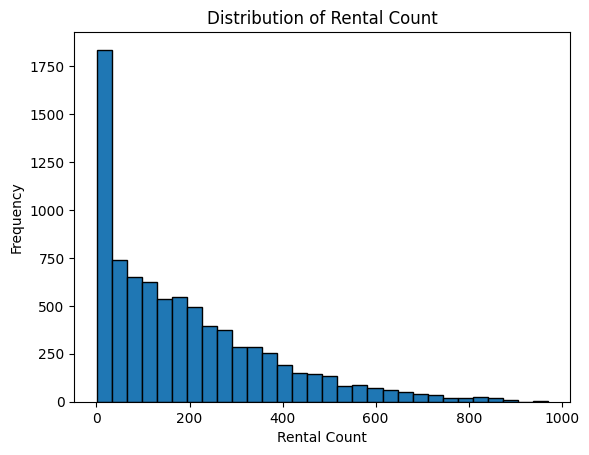

In [94]:

plt.hist(train_with_labels['count'], bins=30, edgecolor='black')
plt.title('Distribution of Rental Count')
plt.xlabel('Rental Count')
plt.ylabel('Frequency')
plt.show()


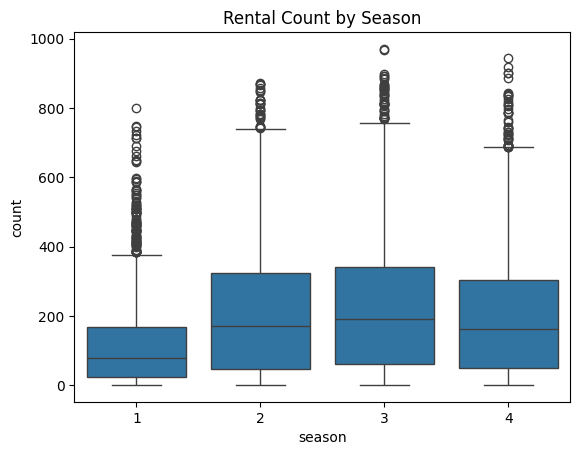

In [95]:
# Box Plot for Target Variable vs. Categorical Features to explore how the target variable varies across different categories.
sns.boxplot(x='season', y='count', data=train_with_labels)
plt.title('Rental Count by Season')
plt.show()



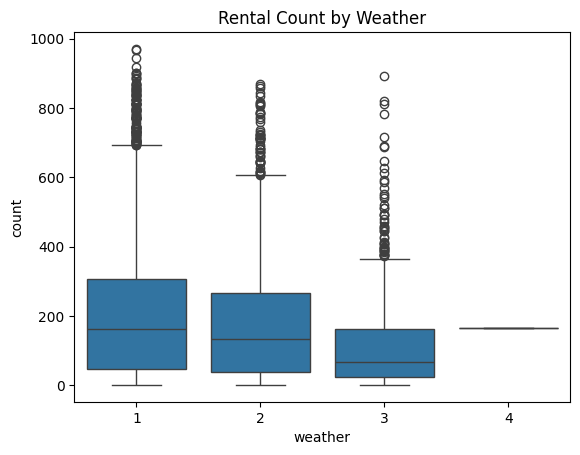

In [96]:
sns.boxplot(x='weather', y='count', data=train_with_labels)
plt.title('Rental Count by Weather')
plt.show()


From the visualization above, we get the following insights:
- The 'season' feature exhibits a relatively uniform distribution across its categories, suggesting a balanced representation in the training data.
- However, the 'weather' displays an imbalance.
 Specifically, it seeems like there are no observations recorded for weather category 4, and a majority of the observations fall into weather categories 1 and 2 compared to category 3.
 This observation suggests a potential imbalance in the training data, a factor to be mindful of in the subsequent preprocessing step.

 trying to learn about the relationships between numerical features and the target variable using a correlation matrix

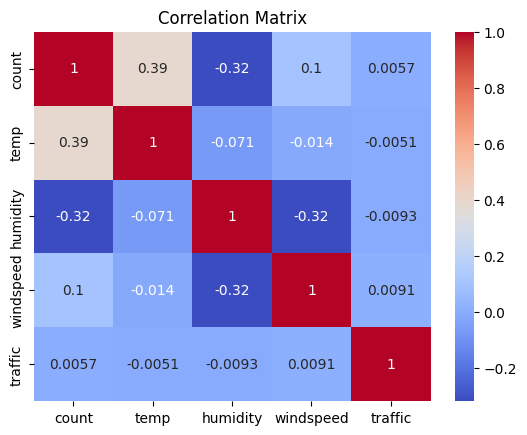

In [97]:
correlation_matrix = train_with_labels[['count', 'temp', 'humidity', 'windspeed', 'traffic']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Correlation from another look:

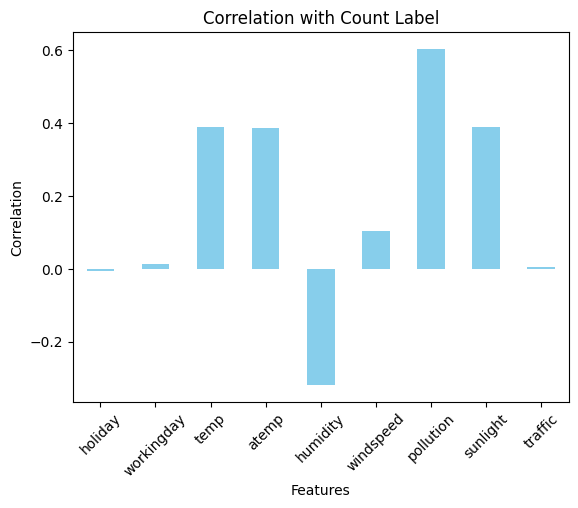

In [98]:

plt.figure()
correlation_matrix = train_with_labels.corr()
correlation_with_label = correlation_matrix['count']

# Remove the label feature from the correlation
correlation_with_label = correlation_with_label.drop('count')

correlation_with_label.plot(kind='bar', color='skyblue')
plt.title('Correlation with Count Label')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()


The resulting plot shows the correlation values between each feature and the 'label' column, providing insights into the relationship between the features and the malicious label. We can see that there is no feature that is very correlated with the labels.<br>
Can not draw any conclusion. TODO

# **Features Analysis**

## Categorical Features distribution

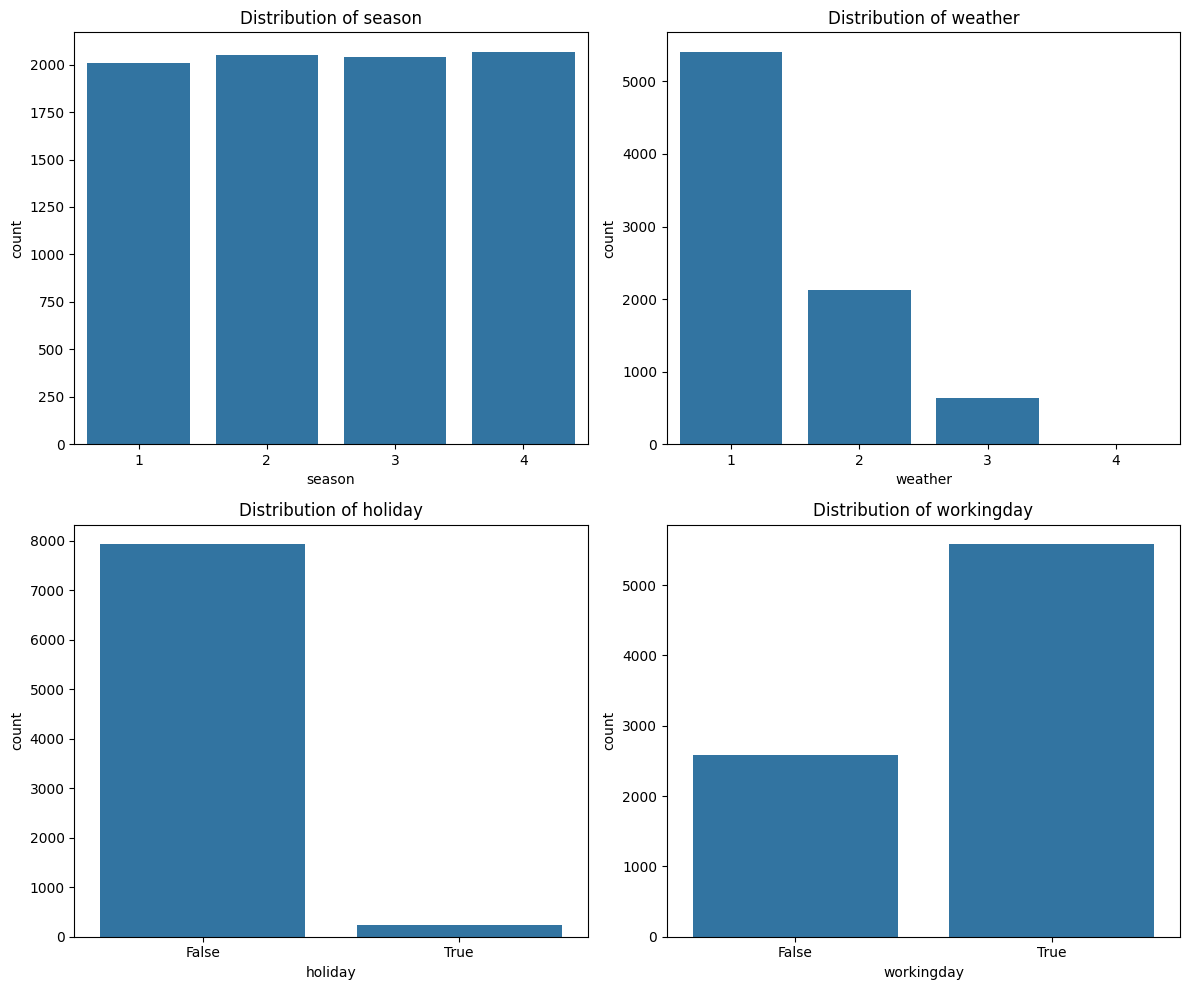

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

boolean_features = [col for col in ['holiday', 'workingday'] if col in train_data.columns]
categorical_features = [col for col in ['season', 'weather'] if col in train_data.columns]

# Plot categorical features
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=train_data, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Distribution of {feature}')

# Plot boolean features
for i, feature in enumerate(boolean_features):
  sns.countplot(x=feature, data=train_data, ax=axes[1, i])
  axes[1, i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()



From a first look, we can see that : <br>
The 'season' feature has comparable numbers of rental bikes for each season, indicating that the demand for bikes remains consistent throughout the year.

On the other hand, The 'weather' count plot indicates that they are no bikes rental during a '4' weather, which is a heavy weather.

In addition, we observed that people are often rent bikes during working days and not on a holiday.  

Let's see the numbers:

In [100]:
def categorial_repr_of_features(df, features):
  for column in features:
      categories = df[column].value_counts()
      print(f"Categories in column '{column}':")
      display(categories)
      # Noting when the categories are unique.
      if len(categories) == df.shape[0]:
          print("Each category is different.")
      print(f"Number of categories: " , len(categories), '\n')

In [101]:
categorial_repr_of_features(train_data, ['holiday', 'workingday', 'season', 'weather'])

Categories in column 'holiday':


False    7924
True      240
Name: holiday, dtype: Int64

Number of categories:  2 

Categories in column 'workingday':


True     5578
False    2586
Name: workingday, dtype: Int64

Number of categories:  2 

Categories in column 'season':


4    2067
2    2051
3    2039
1    2007
Name: season, dtype: int64

Number of categories:  4 

Categories in column 'weather':


1    5406
2    2125
3     632
4       1
Name: weather, dtype: int64

Number of categories:  4 



TODO

 ## **Date time Features - Time Series**

In this section we will check the time series attributes that the data has:

As we saw on the first rows of our data, the Datetime feature is not sorted by day, month and year. <br>
Therefore we will sort it :

In [102]:
train_data.dtypes

datetime      datetime64[ns]
season              category
holiday              boolean
workingday           boolean
weather             category
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
pollution            float64
sunlight             float64
traffic              float64
dtype: object

Before separating the 'datetime' feature to sub features, we will check whether there are minutes and hours:

In [103]:
unique_times = train_data['datetime'].dt.strftime('%H:%M:%S').unique()

sorted_times = sorted(unique_times)

print("All unique times in train_data['datetime'], sorted:")
for time in sorted_times:
  print(time)

All unique times in train_data['datetime'], sorted:
00:00:00
01:00:00
02:00:00
03:00:00
04:00:00
05:00:00
06:00:00
07:00:00
08:00:00
09:00:00
10:00:00
11:00:00
12:00:00
13:00:00
14:00:00
15:00:00
16:00:00
17:00:00
18:00:00
19:00:00
20:00:00
21:00:00
22:00:00
23:00:00


We observe that the 'datetime' column only includes hours without minutes and seconds. Therefore, we will add new features specifically for hours, days, month and year.

In [104]:
def timeseries_engineering(df):
  df['day'] = df['datetime'].dt.day
  df['month'] = df['datetime'].dt.month
  df['year'] = df['datetime'].dt.year
  df['hour'] = df['datetime'].dt.hour
  df['is_weekend'] = df['datetime'].dt.dayofweek // 5
  df = df.sort_values(by='datetime')
  return df

These new features will replace the datetime feature when training the models.
For now, we will leave the datetime feature in order to perform additional analysis on it.

In [113]:
train_data = timeseries_engineering(train_data)
train_with_labels = timeseries_engineering(train_with_labels)
test_data = timeseries_engineering(test_data)

In [106]:
train_with_labels.dtypes

datetime      datetime64[ns]
season              category
holiday              boolean
workingday           boolean
weather             category
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
pollution            float64
sunlight             float64
traffic              float64
count                  int64
day                    int64
month                  int64
year                   int64
hour                   int64
is_weekend             int64
dtype: object

Let's look at the sorted data and maybe draw some new conclusions:

In [109]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,day,month,year,hour,is_weekend
6560,2011-01-01 01:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,10.820673,9.021,0.000000,1,1,2011,1,1
3754,2011-01-01 02:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,19.189498,9.021,0.004489,1,1,2011,2,1
7767,2011-01-01 04:00:00,1,False,False,1,9.84,14.395,75.0,0.0000,0.133472,9.841,0.015615,1,1,2011,4,1
7272,2011-01-01 05:00:00,1,False,False,2,9.84,12.880,75.0,6.0032,0.014335,9.841,0.000000,1,1,2011,5,1
5381,2011-01-01 06:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,0.096936,9.021,0.004489,1,1,2011,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,2012-12-19 16:00:00,4,False,True,1,17.22,21.210,50.0,23.9994,19.956957,17.221,0.015615,19,12,2012,16,0
467,2012-12-19 18:00:00,4,False,True,1,15.58,19.695,50.0,23.9994,212.578827,15.581,0.004489,19,12,2012,18,0
4423,2012-12-19 19:00:00,4,False,True,1,15.58,19.695,50.0,26.0027,21.027171,15.581,0.015615,19,12,2012,19,0
3307,2012-12-19 20:00:00,4,False,True,1,14.76,17.425,57.0,15.0013,37.737255,14.761,0.004489,19,12,2012,20,0


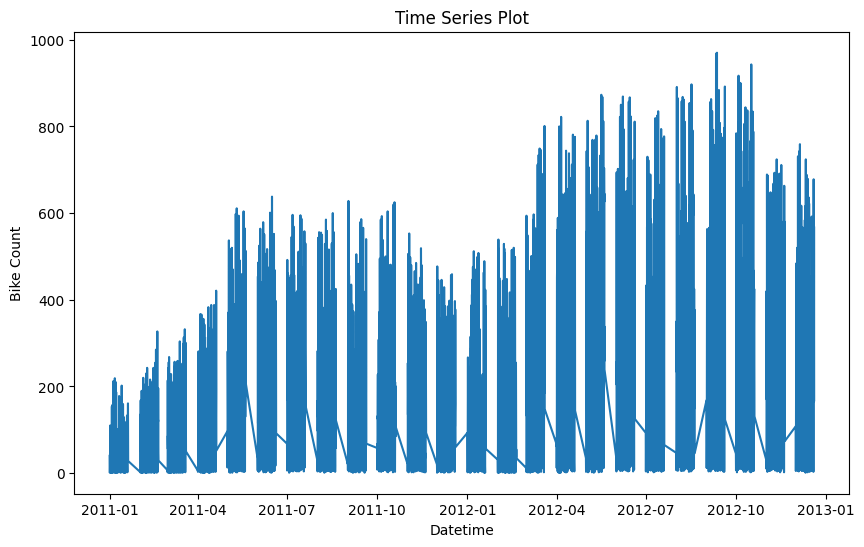

In [32]:
# Assuming 'datetime_column' is your datetime feature and 'target_variable' is the variable of interest
plt.figure(figsize=(10, 6))
plt.plot(train_with_labels['datetime'], train_with_labels['count'])
plt.title('Time Series Plot')
plt.xlabel('Datetime')
plt.ylabel('Bike Count')
plt.show()

In [40]:
start = str(train_data['datetime'].min())
end = str(train_data['datetime'].max())

print("Start: " + start[:10], "   Time: " + start[11:], "\nEnd:   " + end[:10], "   Time: " + end[11:])

Start: 2011-01-01    Time: 01:00:00 
End:   2012-12-19    Time: 21:00:00


In [131]:
# Calculate expected number of days
start = pd.to_datetime(start)
end = pd.to_datetime(end)

expected_dates = pd.date_range(start, end)
actual_dates = train_data['datetime'].dt.date.unique()

# Get actual unique dates
# dates = train_data['datetime'].dt.floor('D').unique()
expected_days = (end - start).days + 1
actual_days = len(actual_dates)

print(f'Expected Days: {expected_days}')
print(f'Actual Days: {actual_days}\n')

missing_dates = set(expected_dates) - set(actual_dates)

if len(missing_dates) > 0:
    print("Missing dates:")
    missing_dates = sorted(missing_dates)
    for date in missing_dates:
        print(str(date)[:10])
else:
    print("No missing dates")

Expected Days: 719
Actual Days: 456

Missing dates:
2011-01-01
2011-01-02
2011-01-03
2011-01-04
2011-01-05
2011-01-06
2011-01-07
2011-01-08
2011-01-09
2011-01-10
2011-01-11
2011-01-12
2011-01-13
2011-01-14
2011-01-15
2011-01-16
2011-01-17
2011-01-18
2011-01-19
2011-01-20
2011-01-21
2011-01-22
2011-01-23
2011-01-24
2011-01-25
2011-01-26
2011-01-27
2011-01-28
2011-01-29
2011-01-30
2011-01-31
2011-02-01
2011-02-02
2011-02-03
2011-02-04
2011-02-05
2011-02-06
2011-02-07
2011-02-08
2011-02-09
2011-02-10
2011-02-11
2011-02-12
2011-02-13
2011-02-14
2011-02-15
2011-02-16
2011-02-17
2011-02-18
2011-02-19
2011-02-20
2011-02-21
2011-02-22
2011-02-23
2011-02-24
2011-02-25
2011-02-26
2011-02-27
2011-02-28
2011-03-01
2011-03-02
2011-03-03
2011-03-04
2011-03-05
2011-03-06
2011-03-07
2011-03-08
2011-03-09
2011-03-10
2011-03-11
2011-03-12
2011-03-13
2011-03-14
2011-03-15
2011-03-16
2011-03-17
2011-03-18
2011-03-19
2011-03-20
2011-03-21
2011-03-22
2011-03-23
2011-03-24
2011-03-25
2011-03-26
2011-03-27
20

In [137]:
expected_dates

DatetimeIndex(['2011-01-01 01:00:00', '2011-01-02 01:00:00',
               '2011-01-03 01:00:00', '2011-01-04 01:00:00',
               '2011-01-05 01:00:00', '2011-01-06 01:00:00',
               '2011-01-07 01:00:00', '2011-01-08 01:00:00',
               '2011-01-09 01:00:00', '2011-01-10 01:00:00',
               ...
               '2012-12-10 01:00:00', '2012-12-11 01:00:00',
               '2012-12-12 01:00:00', '2012-12-13 01:00:00',
               '2012-12-14 01:00:00', '2012-12-15 01:00:00',
               '2012-12-16 01:00:00', '2012-12-17 01:00:00',
               '2012-12-18 01:00:00', '2012-12-19 01:00:00'],
              dtype='datetime64[ns]', length=719, freq='D')

In [136]:
missing_dates

[Timestamp('2011-01-01 01:00:00', freq='D'),
 Timestamp('2011-01-02 01:00:00', freq='D'),
 Timestamp('2011-01-03 01:00:00', freq='D'),
 Timestamp('2011-01-04 01:00:00', freq='D'),
 Timestamp('2011-01-05 01:00:00', freq='D'),
 Timestamp('2011-01-06 01:00:00', freq='D'),
 Timestamp('2011-01-07 01:00:00', freq='D'),
 Timestamp('2011-01-08 01:00:00', freq='D'),
 Timestamp('2011-01-09 01:00:00', freq='D'),
 Timestamp('2011-01-10 01:00:00', freq='D'),
 Timestamp('2011-01-11 01:00:00', freq='D'),
 Timestamp('2011-01-12 01:00:00', freq='D'),
 Timestamp('2011-01-13 01:00:00', freq='D'),
 Timestamp('2011-01-14 01:00:00', freq='D'),
 Timestamp('2011-01-15 01:00:00', freq='D'),
 Timestamp('2011-01-16 01:00:00', freq='D'),
 Timestamp('2011-01-17 01:00:00', freq='D'),
 Timestamp('2011-01-18 01:00:00', freq='D'),
 Timestamp('2011-01-19 01:00:00', freq='D'),
 Timestamp('2011-01-20 01:00:00', freq='D'),
 Timestamp('2011-01-21 01:00:00', freq='D'),
 Timestamp('2011-01-22 01:00:00', freq='D'),
 Timestamp

In [135]:
unique_dates = train_data['datetime'].dt.date.unique()
unique_dates

array([datetime.date(2011, 1, 1), datetime.date(2011, 1, 2),
       datetime.date(2011, 1, 3), datetime.date(2011, 1, 4),
       datetime.date(2011, 1, 5), datetime.date(2011, 1, 6),
       datetime.date(2011, 1, 7), datetime.date(2011, 1, 8),
       datetime.date(2011, 1, 9), datetime.date(2011, 1, 10),
       datetime.date(2011, 1, 11), datetime.date(2011, 1, 12),
       datetime.date(2011, 1, 13), datetime.date(2011, 1, 14),
       datetime.date(2011, 1, 15), datetime.date(2011, 1, 16),
       datetime.date(2011, 1, 17), datetime.date(2011, 1, 18),
       datetime.date(2011, 1, 19), datetime.date(2011, 2, 1),
       datetime.date(2011, 2, 2), datetime.date(2011, 2, 3),
       datetime.date(2011, 2, 4), datetime.date(2011, 2, 5),
       datetime.date(2011, 2, 6), datetime.date(2011, 2, 7),
       datetime.date(2011, 2, 8), datetime.date(2011, 2, 9),
       datetime.date(2011, 2, 10), datetime.date(2011, 2, 11),
       datetime.date(2011, 2, 12), datetime.date(2011, 2, 13),
       dat

In [ ]:
date_strings = [str(date) for date in unique_dates]

date_strings

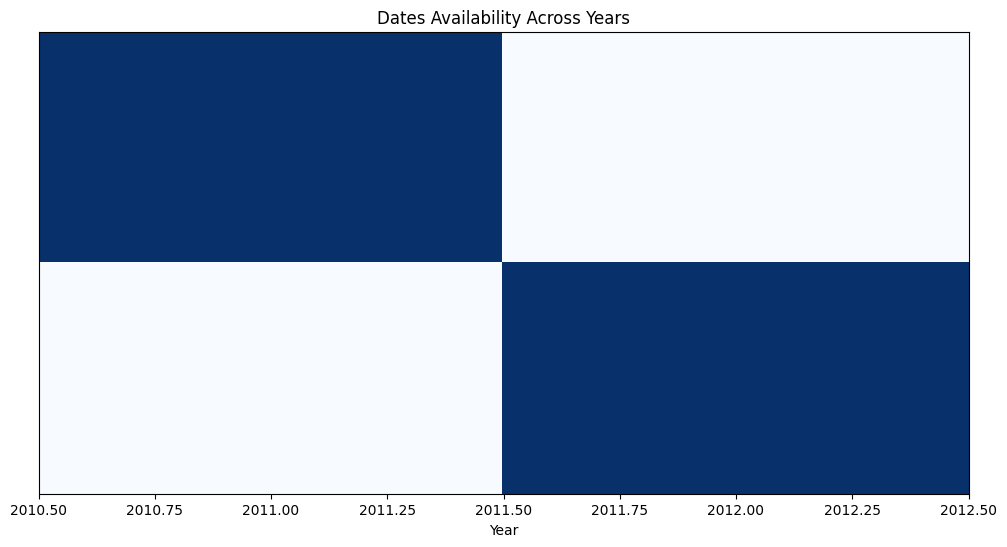

In [118]:
def plot_dates_availability(unique_dates):
    # Convert the NumPy array to a pandas DatetimeIndex
    unique_dates = pd.to_datetime(unique_dates)

    # Create a DataFrame with binary values indicating date presence
    df = pd.DataFrame(index=unique_dates, columns=range(min(unique_dates.year), max(unique_dates.year)+1))

    for date in unique_dates:
        df.at[date, date.year] = 1

    # Fill missing values with 0
    df = df.fillna(0)

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.imshow(df.T, cmap='Blues', aspect='auto', interpolation='none', extent=[min(unique_dates.year)-0.5, max(unique_dates.year)+0.5, 0, 1])
    plt.title('Dates Availability Across Years')
    plt.xlabel('Year')
    plt.yticks([])
    plt.show()

# Example usage:
# Assuming 'unique_dates' is a pandas DatetimeIndex
plot_dates_availability(actual_dates)

In [46]:
def plot_dates_availability(appear_dates, missing_dates):
    # Convert date strings or numpy.datetime64 objects to datetime objects considering only the day
    appear_dates = [pd.to_datetime(date).date() for date in appear_dates]
    missing_dates = [pd.to_datetime(date).date() for date in missing_dates]

    # Create a plot with two sets of points (appear and missing)
    plt.figure(figsize=(10, 6))

    # Plot dates that appeared
    plt.scatter(appear_dates, np.ones(len(appear_dates)), color='green', label='Appeared', marker='o', alpha=0.7)

    # Plot dates that are missing
    plt.scatter(missing_dates, np.ones(len(missing_dates)), color='red', label='Missing', marker='x', alpha=0.7)

    # Customize the plot
    plt.title('Dates Availability')
    plt.xlabel('Dates')
    plt.yticks([])  # Remove y-axis ticks
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()


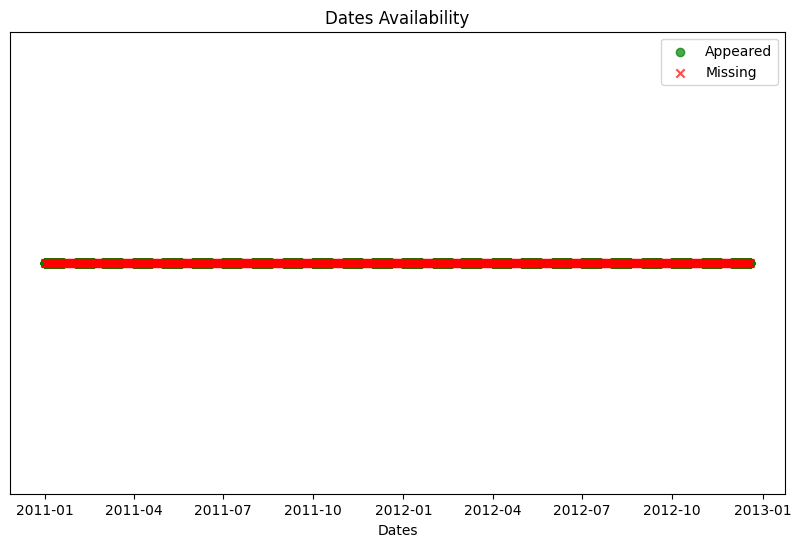

In [47]:
plot_dates_availability(actual_dates, missing_dates)

In [49]:
def plot_dates_availability_barplot(appear_dates, missing_dates):
    # Convert date strings or numpy.datetime64 objects to datetime objects considering only the day
    appear_dates = [pd.to_datetime(date).date() for date in appear_dates]
    missing_dates = [pd.to_datetime(date).date() for date in missing_dates]

    # Count the occurrences of each date type
    appear_counts = pd.Series(appear_dates).value_counts().sort_index()
    missing_counts = pd.Series(missing_dates).value_counts().sort_index()

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    appear_counts.plot(kind='bar', color='green', label='Appeared', alpha=0.7)
    missing_counts.plot(kind='bar', color='red', label='Missing', alpha=0.7)

    # Customize the plot
    plt.title('Dates Availability')
    plt.xlabel('Dates')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


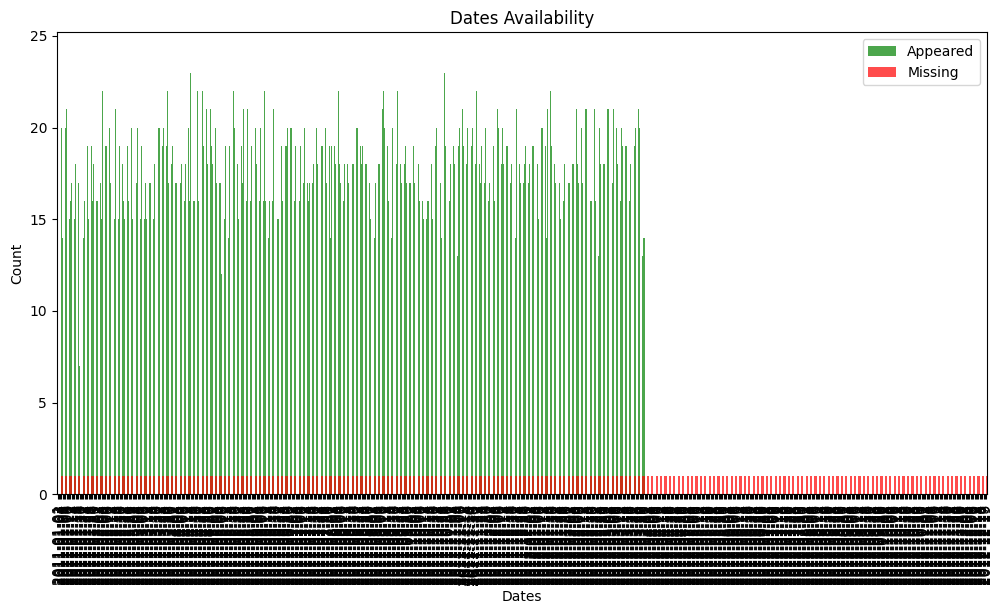

In [50]:
plot_dates_availability_barplot(actual_dates, missing_dates)

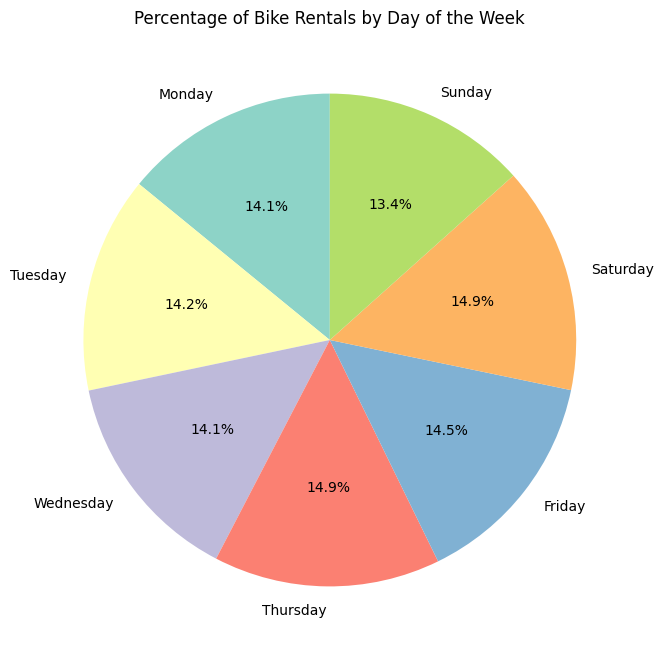

In [ ]:

# Assuming 'bike_data' includes the new datetime-related features
train_with_labels['day_of_week'] = train_with_labels['datetime'].dt.dayofweek

# Group by day of the week and calculate the total count
total_counts_by_day = train_with_labels.groupby('day_of_week')['count'].sum()

# Calculate the percentage of rentals for each day
percentage_rentals_by_day = (total_counts_by_day / total_counts_by_day.sum()) * 100

# Days of the week labels
days_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentage_rentals_by_day, labels=days_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Percentage of Bike Rentals by Day of the Week')
plt.show()

From the visualization above of the bike rental percentages for each day, we observe a consistent pattern throughout the week.
The rental percentage remains relatively stable at between 14.1%  and 14.9% for each day, except for Sunday, where it slightly decreases to 13.4%. This slight deviation aligns with expectations as Sunday is typically a non-working day.
But we consider the variation as minimal, so we could say it is a fairly uniform distribution of bike rentals across the days of the week, with Sunday being only marginally lower but still in close proximity to the 14% mark observed on other days.

##  **Numerical Features Distribution**

Next, we want to observe some statistics to understand what data we have: <br>
(Note that we are only looking at the numerical features and boolean features - which are represented as numbers).

In [ ]:
# Get the summary statistics of the features
print("\nSummary statistics of the features:")
train_data.describe()


Summary statistics of the features:


,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,day,month,year,is_weekend
count,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,20.244980,23.670160,61.835130,12.791334,47.152120,20.245980,0.004986,9.947085,6.533562,2011.502205,0.287359
std,7.796018,8.468725,19.255791,8.213914,72.882602,7.796018,0.006319,5.466515,3.439504,0.500026,0.452558
min,0.820000,0.760000,0.000000,0.000000,0.000304,0.821000,0.000000,1.000000,1.000000,2011.000000,0.000000
25%,13.940000,16.665000,47.000000,7.001500,3.693188,13.941000,0.000000,5.000000,4.000000,2011.000000,0.000000
50%,20.500000,24.240000,62.000000,12.998000,17.684113,20.501000,0.000242,10.000000,7.000000,2012.000000,0.000000
75%,26.240000,31.060000,77.000000,16.997900,59.257746,26.241000,0.004489,15.000000,10.000000,2012.000000,1.000000
max,41.000000,45.455000,100.000000,56.996900,754.304876,41.001000,0.015615,19.000000,12.000000,2012.000000,1.000000


Based on this information, we can make the following observations: (Generated by GPT)

Here are some conclusions and observations that can be drawn from the train_data dataframe based on the provided statistics:

- <u>Temperature and Apparent Temperature (temp & atemp):</u>

    The mean temperature is around 20.24°C, with a standard deviation of 7.80°C.
    Apparent temperature (atemp) has a similar distribution to temperature.


- <u>Humidity:</u>

    The average humidity is approximately 61.84%, with a standard deviation of 19.26%.
    The minimum humidity is 0%, which might be an outlier or missing data.


- <u>Windspeed:</u>

    The average windspeed is 12.79, with a standard deviation of 8.21.
    There is a wide range of windspeed values, with a minimum of 0 and a maximum of 56.9979.


- <u>Pollution:</u>

    The pollution level has a mean of 47.15, but with a high standard deviation of 72.88.
    The pollution values range from a minimum of 0.000304 to a maximum of 754.30, suggesting potential outliers.


- <u>Sunlight:</u>

    The average sunlight is 20.25, with a standard deviation of 7.80.
    Sunlight values range from a minimum of 0.821 to a maximum of 41.001.
    Seems like it is correlated to temperature...


- <u>Traffic:</u>

    The traffic variable has a very low mean of 0.00499, with a standard deviation of 0.00632.
    The majority of the values seem to be close to zero, suggesting sparse traffic data. Its impact on the bicycle rental demand needs exploration.

Now we would like to understand how the features are structured. <br>
Are the values in each feature repeated ...? What are common values in every feature ...? Is an attribute a representative attribute with different values ...?

In [ ]:
# relevant_features = ['datetime#, 'temp', 'atemp', ] # TODO

categorial_repr_of_features(train_data, numeric_features)


Categories in column 'temp':


14.76    351
26.24    344
18.86    317
28.70    313
13.94    308
22.14    308
22.96    304
12.30    300
24.60    300
27.06    297
25.42    295
16.40    286
29.52    270
13.12    270
21.32    266
17.22    265
10.66    259
20.50    252
18.04    241
30.34    218
9.84     209
15.58    181
9.02     180
31.16    176
8.20     169
27.88    168
32.80    146
23.78    146
11.48    140
19.68    131
6.56     109
33.62     97
5.74      87
7.38      77
31.98     75
35.26     60
34.44     58
4.92      41
36.90     37
4.10      34
37.72     27
36.08     21
3.28       9
38.54      7
0.82       6
39.36      5
2.46       2
1.64       1
41.00      1
Name: temp, dtype: int64

Number of categories:  49 

Categories in column 'atemp':


31.060    506
25.760    325
22.725    317
26.515    304
16.665    292
20.455    286
25.000    269
21.210    265
33.335    261
30.305    256
15.150    256
24.240    252
21.970    241
17.425    232
31.820    228
34.850    217
14.395    207
27.275    205
32.575    204
29.545    204
11.365    194
15.910    191
13.635    189
12.880    183
19.695    181
34.090    160
12.120    157
23.485    131
28.790    125
10.605    119
35.605    118
9.850      98
18.180     94
36.365     93
37.120     92
9.090      78
37.880     75
28.030     59
7.575      59
38.635     55
6.060      49
39.395     46
6.820      46
8.335      41
40.910     34
18.940     33
40.150     31
5.305      20
42.425     20
41.665     18
3.790      11
4.545       8
3.030       6
2.275       6
43.180      6
43.940      6
44.695      2
45.455      1
1.515       1
0.760       1
Name: atemp, dtype: int64

Number of categories:  60 

Categories in column 'humidity':


88.0    292
94.0    238
83.0    227
87.0    215
65.0    197
       ... 
13.0      1
97.0      1
10.0      1
12.0      1
14.0      1
Name: humidity, Length: 87, dtype: int64

Number of categories:  87 

Categories in column 'windspeed':


0.0000     1000
11.0014     819
8.9981      816
12.9980     783
7.0015      753
15.0013     693
6.0032      675
16.9979     632
19.0012     504
19.9995     359
22.0028     283
23.9994     200
26.0027     174
27.9993     148
30.0026      81
31.0009      69
32.9975      59
35.0008      46
39.0007      21
36.9974      19
40.9973       9
43.9989       7
43.0006       7
56.9969       2
47.9988       2
50.0021       1
46.0022       1
51.9987       1
Name: windspeed, dtype: int64

Number of categories:  28 

Categories in column 'pollution':


5.354100     1
37.984932    1
12.358278    1
13.664858    1
0.092407     1
            ..
51.134165    1
5.178513     1
3.214959     1
21.849634    1
81.965417    1
Name: pollution, Length: 8164, dtype: int64

Each category is different.
Number of categories:  8164 

Categories in column 'sunlight':


14.761    351
26.241    344
18.861    317
28.701    313
13.941    308
22.141    308
22.961    304
12.301    300
24.601    300
27.061    297
25.421    295
16.401    286
29.521    270
13.121    270
21.321    266
17.221    265
10.661    259
20.501    252
18.041    241
30.341    218
9.841     209
15.581    181
9.021     180
31.161    176
8.201     169
27.881    168
32.801    146
23.781    146
11.481    140
19.681    131
6.561     109
33.621     97
5.741      87
7.381      77
31.981     75
35.261     60
34.441     58
4.921      41
36.901     37
4.101      34
37.721     27
36.081     21
3.281       9
38.541      7
0.821       6
39.361      5
2.461       2
1.641       1
41.001      1
Name: sunlight, dtype: int64

Number of categories:  49 

Categories in column 'traffic':


0.000000    2090
0.000242    2088
0.015615    2005
0.004489    1981
Name: traffic, dtype: int64

Number of categories:  4 



We can draw some interesting conclusions: (Generated by GPT)

- <u>Datetime:</u>

    Each timestamp in the 'datetime' column is unique, indicating that there are no duplicated timestamp values. This column might represent the date and time information. TODO Remove maybe (seperate section)


- <u>Season:</u>

    There are four distinct categories in the 'season' column (1, 2, 3, 4) with varying counts.
    The distribution suggests that each season is well-represented in the dataset.


- <u>Holiday and Workingday:</u>

    The 'holiday' column has two categories (0, 1) with the majority being non-holiday days (0).
    The 'workingday' column has two categories (0, 1), with a higher count for working days (1).


- <u>Weather:</u>

    The 'weather' column has four categories (1, 2, 3, 4), with the majority falling under category 1.
    Category 4 appears to have only one occurrence and might be an outlier or error.


- <u>Temperature and Apparent Temperature (temp, atemp):</u>

    Both 'temp' and 'atemp' columns have a wide range of values, with multiple occurrences for each temperature.
    These features appear to have been discretized or rounded, resulting in multiple instances of the same temperature.


- <u>Humidity:</u>

    The 'humidity' column has 87 unique values, indicating a diverse range of humidity levels in the dataset.


- <u>Windspeed:</u>

    The 'windspeed' column has 29 unique values, with a dominant occurrence of 0.0000.
    It's possible that the windspeed values have been discretized, and 0.0000 might represent calm or very low windspeed.


- <u>Pollution:</u>

    Each value in the 'pollution' column is unique, indicating a diverse range of pollution levels.
    This feature appears to be continuous and might require further investigation for outliers.


- <u>Sunlight:</u>

    Similar to 'temp' and 'atemp', the 'sunlight' column has a variety of values with multiple occurrences for each sunlight level.


- <u>Traffic:</u>

    The 'traffic' column has four distinct values, with the majority being either 0.000000 or 0.000242.
    This variable might represent traffic intensity, and the low values suggest sparse traffic data.

TODO write conclusions

Let's take a look on the distribution of the numerical features to draw some conclusions:

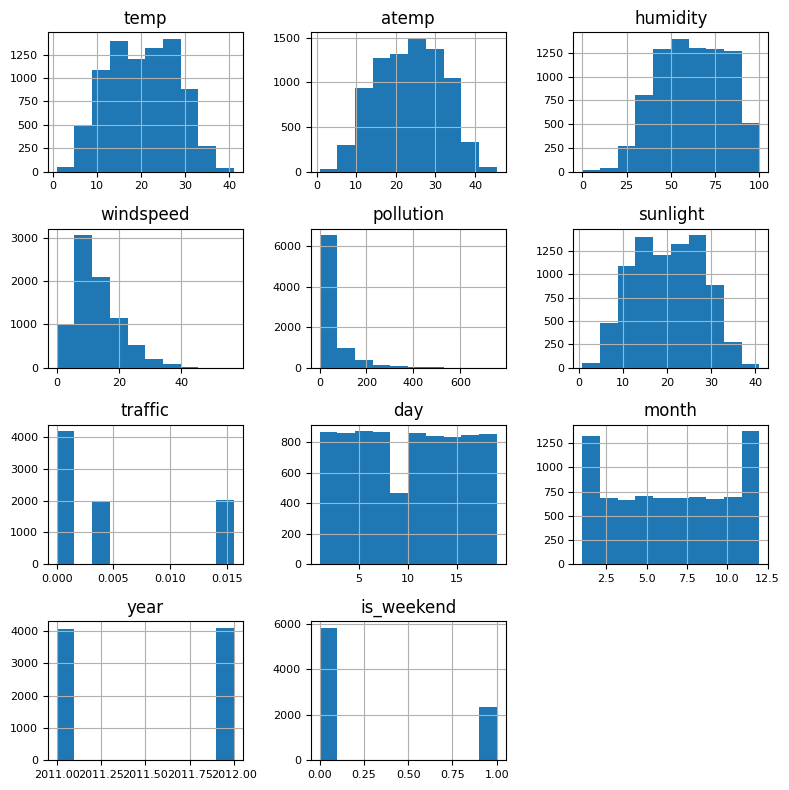

In [ ]:
plt.figure(figsize=(8, 8))
plt.rc('axes', labelsize=4)  # Adjust label font size
plt.rc('xtick', labelsize=8)  # Adjust x-axis tick font size
plt.rc('ytick', labelsize=8)  # Adjust y-axis tick font size
plt.rc('legend', fontsize=8)  # Adjust legend font size

train_data_subset = train_data.drop(columns=['datetime'])

# Plot histograms
train_data_subset.hist(ax=plt.gca())
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Seems that there might be some outliers in "windspeed" and "pollution" as stated above.

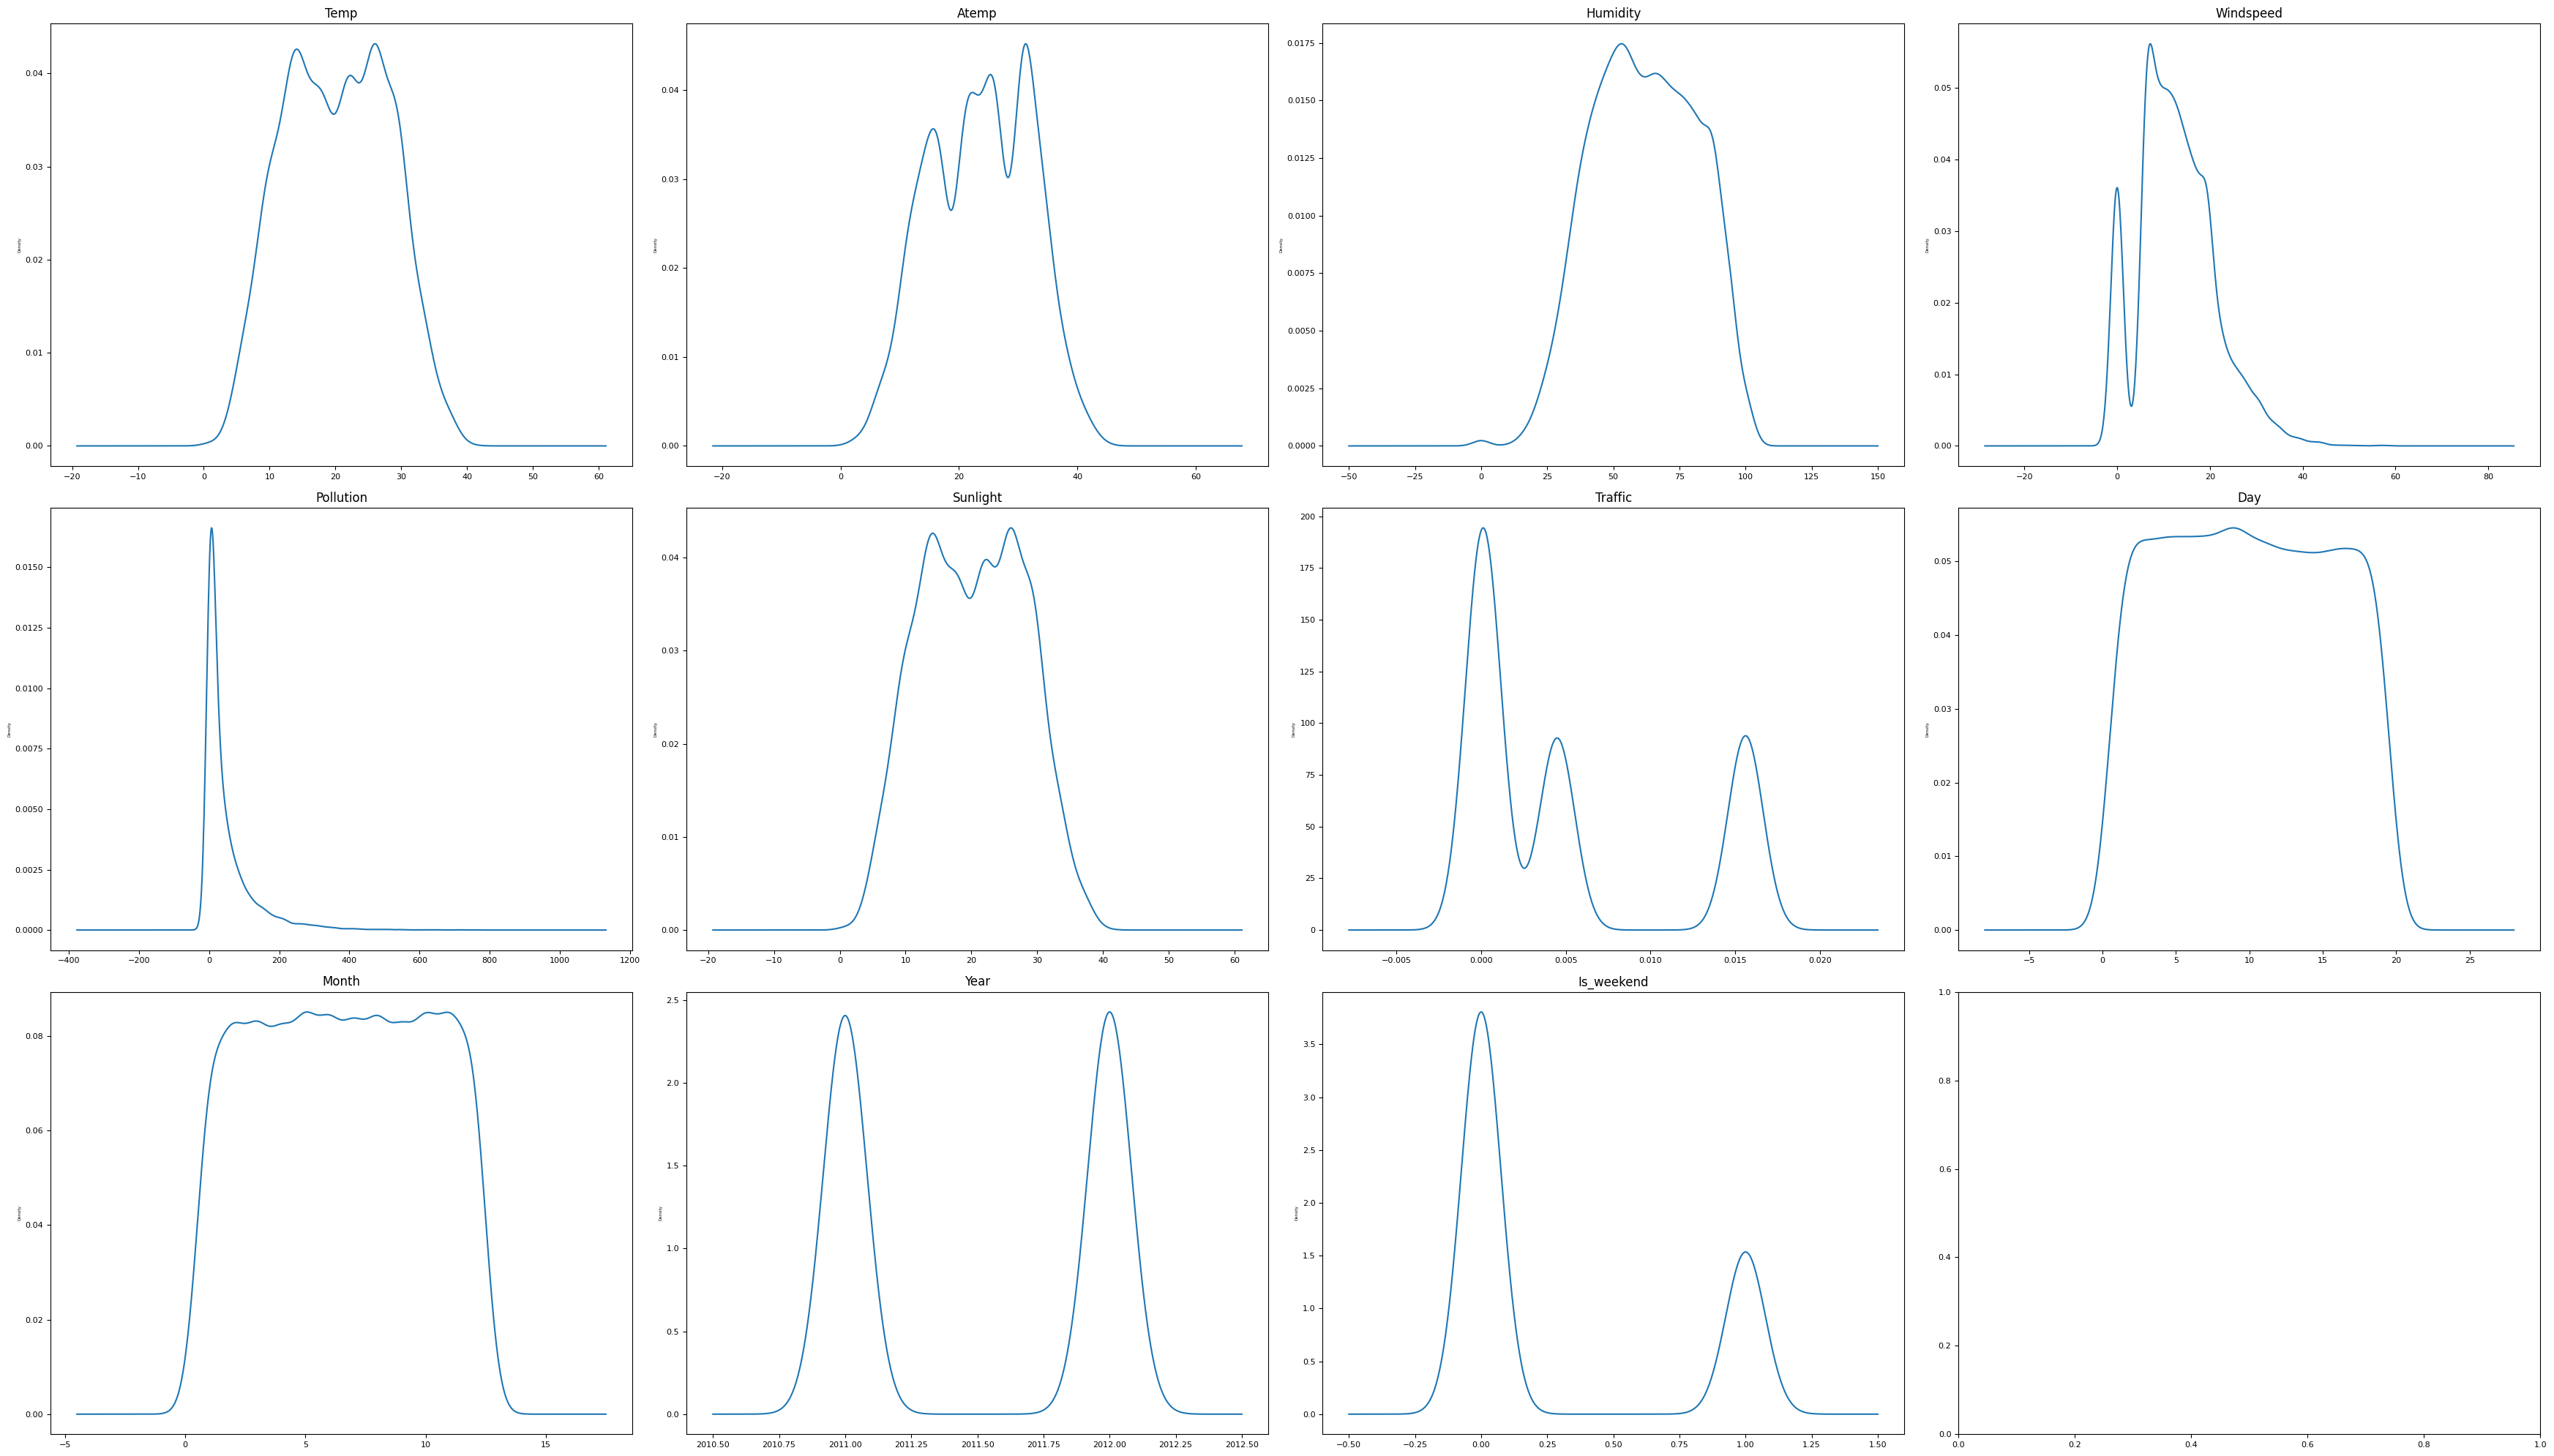

In [ ]:
def create_distribution_graph(df):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    num_cols = len(numeric_cols)
    rows = int(math.sqrt(num_cols))
    cols = int(math.ceil(num_cols / rows))

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(35, 20))

    plot_index = 0
    for i in range(rows):
        for j in range(cols):
            if plot_index < num_cols:
                col = numeric_cols[plot_index]
                df[col].plot.density(ax=axes[i, j])
                axes[i, j].set_title(col.capitalize())
                plot_index += 1

    plt.tight_layout()
    plt.show()

create_distribution_graph(train_data)

"Humidity" and "Pollution" show some type of normality, maybe after some tweaking a better conclusion could be drawn.

We will deal with outliers later.<br>
Hence, let's apply log transformation on these features:

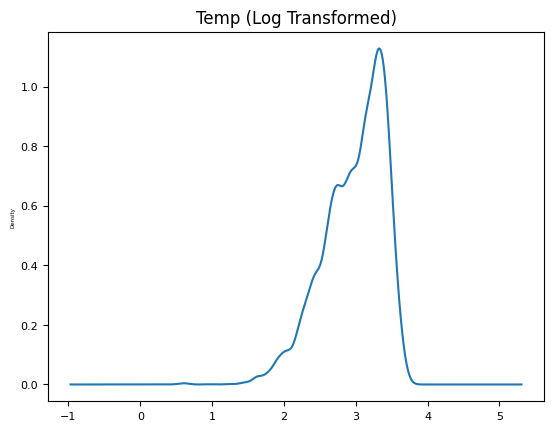

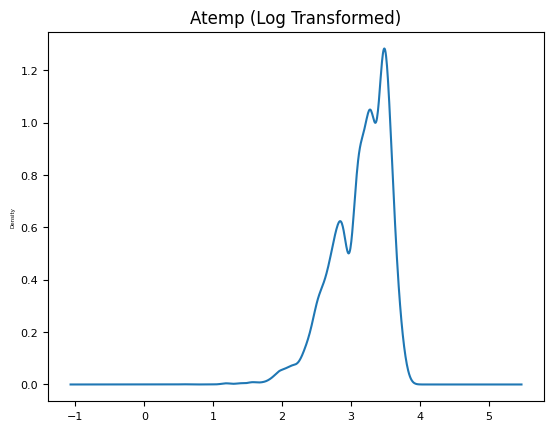

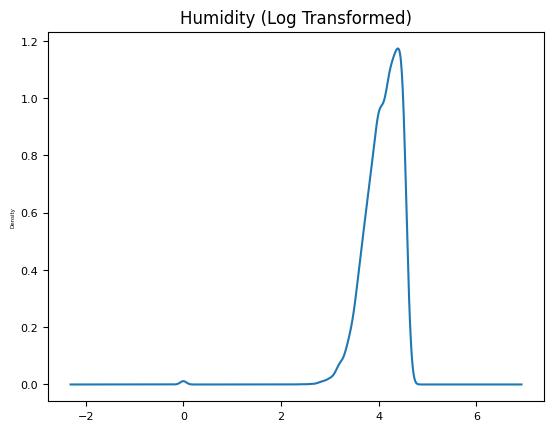

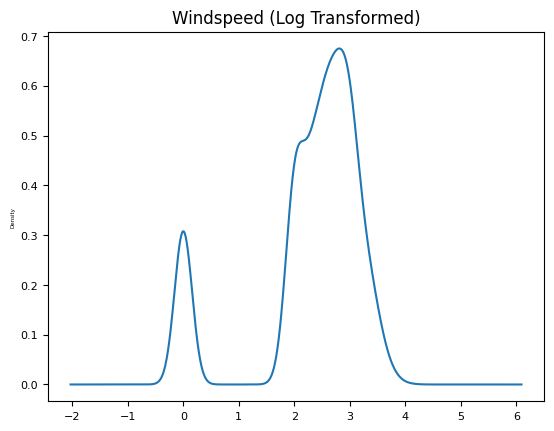

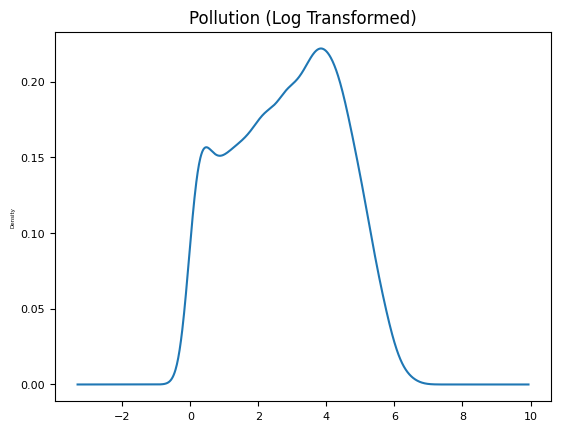

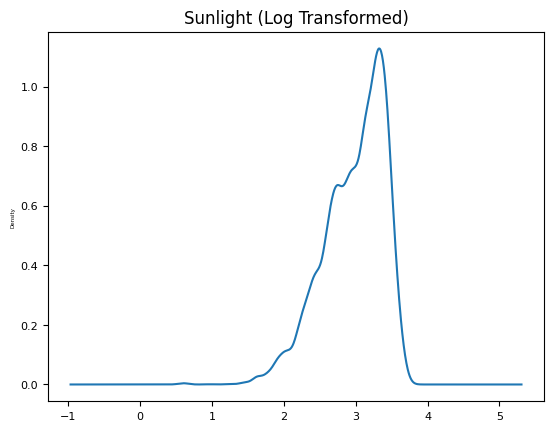

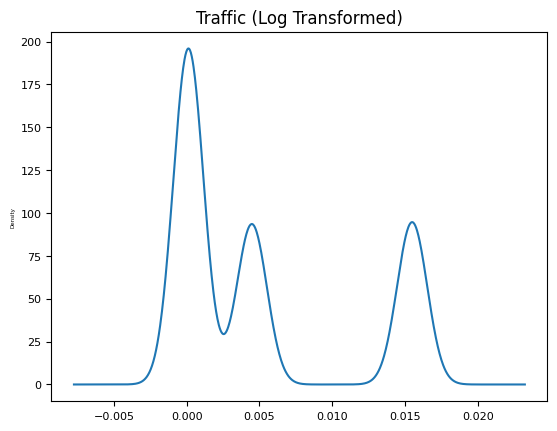

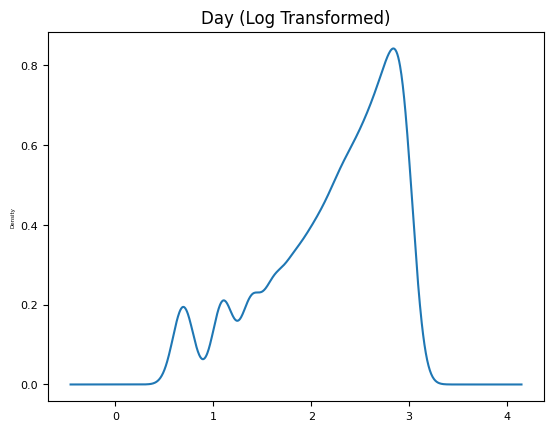

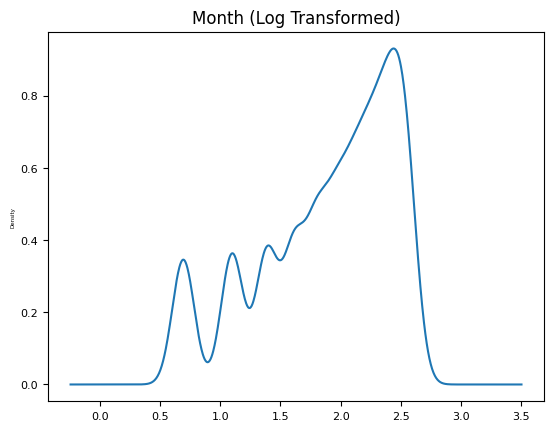

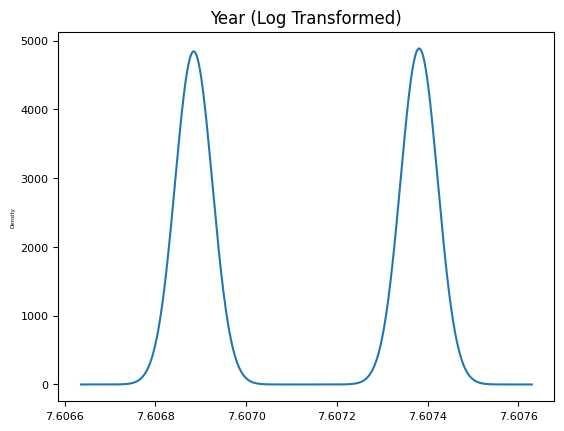

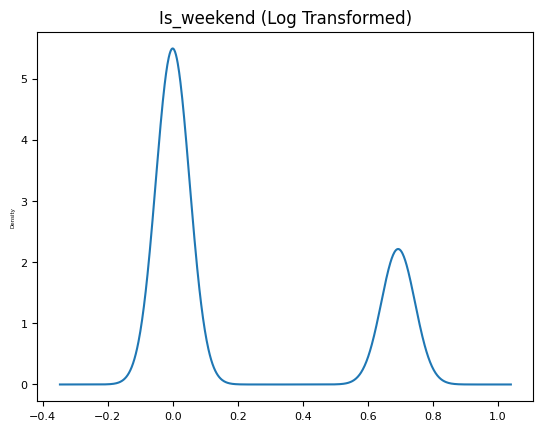

In [ ]:
# Function that creates a distribution graph for all the numeric features
def create_distribution_graph(df):
    for i, col in enumerate(df.select_dtypes(include=[float, int])):
        transformed_data = np.log1p(df[col])  # Apply logarithm transformation
        transformed_data.plot.density()
        plt.title(col.capitalize() + " (Log Transformed)")
        plt.show()

create_distribution_graph(train_data)

Seems like only "Humidity" looks like normaly distributed, but later we will take another look at the distributions and outliers.

TODO

### Correlation
We want to check the correaltion between features.

Let's take a look in general. <br>
In this part we will use a new method which was not learnt in class- the VIF method.
We want primarily observe whether a feature has a high correlation with other features based on its Variance Inflation Factor (VIF) value.<br>
A high VIF value indicates multicollinearity, which suggests a strong correlation between the feature and other features in the dataset.

In [ ]:
# Select numerical features (excluding the categorical features)
numerical_features = train_data.select_dtypes(include=['float64', 'bool'])

# Convert boolean features to numeric (0 and 1)
boolean_features = numerical_features.select_dtypes(include='bool')
boolean_features = numerical_features.dropna()
numerical_features[boolean_features.columns] = boolean_features.astype(int)

# Remove any rows with null values in the selected features
numerical_features = numerical_features.dropna()

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = numerical_features.columns
vif["VIF"] = [variance_inflation_factor(numerical_features.values.astype(float), i) for i in range(numerical_features.shape[1])]

print("VIF for all features except category features:")
print(vif)

VIF for all features except category features:
     Variable         VIF
0     holiday    1.093512
1  workingday    3.142565
2        temp         inf
3       atemp  256.536128
4    humidity    6.189755
5   windspeed    2.765785
6   pollution    1.528149
7    sunlight         inf
8     traffic         NaN


To calculate the VIF, we regress each predictor variable against all the other predictor variables in the model. The VIF for each variable is then computed as the ratio of the variance of the estimated regression coefficient to the variance of the coefficient if that variable was uncorrelated with the other predictors.

Features with VIF values close to 1 (around or below 1) indicate low multicollinearity. These features are relatively independent of each other when predicting the target variable.<br>
Examples: TODO.<br>

Features with VIF values between 1 and 5 are generally considered to have moderate multicollinearity. Although there might be some correlation, it is not severe.<br>
Examples: TODO.<br>

Features with VIF values above 5 suggest the presence of multicollinearity. These features have a strong correlation with other features in the dataset and may negatively impact the model's performance.<br>
Examples: TODO.
<br><br>
Based on this information, we can consider the VIF values to identify potential issues related to multicollinearity.<br>
 High VIF values indicate that certain features are highly correlated with others, which can affect the model's interpretability and stability.<br>
In such cases, we may consider removing or transforming the highly correlated features to mitigate multicollinearity and improve the model's performance.




However, the VIF values alone do not provide information about the specific pairwise correlations between features. <br>
To determine the exact correlations between features, we need to calculate the correlation matrix or pairwise correlation coefficients.

Therefore, we will make a correlation matrix:

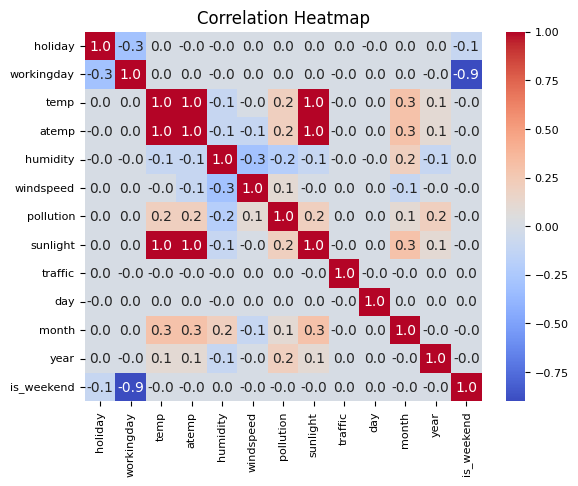

In [ ]:
def corr_matrix(df):
  corr_matrix = train_data.corr().round(1)  # Round the correlation values to 1 decimal place
  plt.figure()
  sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')  # Set fmt='.1f' to display 1 decimal place
  plt.title('Correlation Heatmap')
  plt.show()

corr_matrix(train_data)

This function creates a visual representation of the correlation matrix using a color-coded heatmap.<br>
It displays a grid of squares, where each square represents the correlation between two features.

Here are some general observations we can make from the heatmap:

<b> Strong positive correlation:</b> If two features have a high positive correlation (TODO features), it suggests that as one feature increases, the other feature tends to increase as well. Conversely, if two features have a strong negative correlation (close to -1), it means that as one feature increases, the other feature tends to decrease.

<b>Weak or no correlation:</b> If the correlation coefficient is close to 0, it indicates a weak or no linear relationship between the features (TODO). This means that changes in one feature do not necessarily correspond to changes in the other feature.

<b>Redundant or highly correlated features:</b> High correlation values between pairs of features might indicate that these features provide similar information, in our case: TODO. In such cases, we could consider removing one of the redundant features to reduce dimensionality and potential multicollinearity.<br>
We will use these conclusions later in our analysis.

In [ ]:
#We can see that there is multicollinearity between sunlight & temp & atemp

from sklearn.decomposition import PCA

# Assuming 'features' contains the variables of interest
features = train_data[['sunlight', 'temp', 'atemp']]

pca = PCA(n_components=1)
train_data['pca_combined'] = pca.fit_transform(features)
train_data.drop(['sunlight', 'temp', 'atemp'], axis=1, inplace=True)

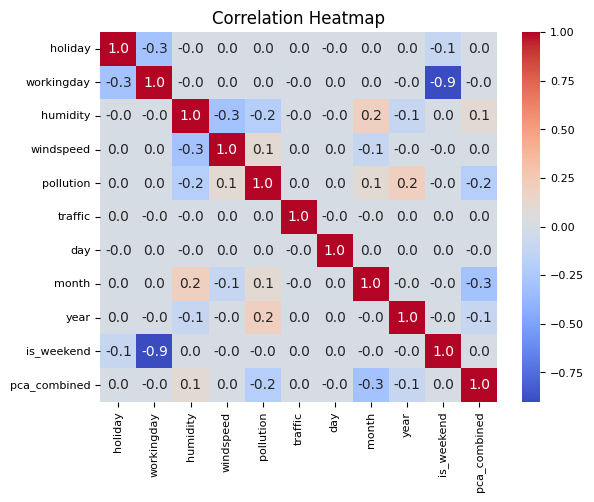

In [ ]:
corr_matrix(train_data)

TODO We can also drop these 3 features (Check in the training process...)

Let's take another look on the high correlated features:

In [ ]:
# Extract the "numstrings" and "size" features from the train_data DataFrame

# TODO : Change based on the findings above

# numstrings = train_data['numstrings'] #TODO
# mz = train_data['MZ']
# size = train_data['size']

# # Plot a scatter plot of the two features
# plt.figure(figsize=(8, 6))
# plt.scatter(numstrings, size, alpha=0.5)
# plt.xlabel('numstrings')
# plt.ylabel('size')
# plt.title('Scatter Plot: numstrings vs size')
# plt.show()

# # Plot a scatter plot of the two features
# plt.figure(figsize=(8, 6))
# plt.scatter(mz, size, alpha=0.5)
# plt.xlabel('MZ')
# plt.ylabel('size')
# plt.title('Scatter Plot: MZ vs size')
# plt.show()


<b>A more in-depth analysis:</b> <br> TODO : Change based on the findings
- <b>numstrings and size</b>

    The "numstrings" feature represents the number of printable strings that are at least five printable characters long. <br>
    This can be an indicator of the amount of text or human-readable content present in the file. <br>
    Larger files are likely to have more text or content, which could explain the higher correlation between the file size and the number of strings.

    It is possible that larger files tend to have more printable strings, or vice versa.

    <b> The VIF values of both these features is high! <br>
    Moreover, looking on the plot, Most of the values are on the linear line.</b>

- <b>MZ and size</b>

    The "MZ" string is a signature commonly found in Windows executable files (PE files) that indicates the file is a Portable Executable format. <br>
    This format is typically used for Windows applications and executables. Therefore, it is expected to observe a higher frequency of the "MZ" string in larger files, as larger files often contain more complex and feature-rich applications.

    To gain a better understanding of the relationship between the "MZ" feature and the file size, <br> we can further investigate the distribution of file sizes for files with and without the "MZ" string.  <br>
    This will help determine if the correlation is significant and consistent across the dataset.

    <b>The VIF values of size is high but the VIF of MZ is low!<br>
    Moreover, looking on the plot, there are a lot of values that are not on the linear line.</b>

In conclusion, the VIF index helped us to understand in general whether there is a correlation for features.<br>
The correlation matrix looked linearly at whether there was a correlation between each 2 features.<br>
In both of these indices we saw that the TODO feature has a very high correlation.<br>
All in all, later, we will maybe consider dropping some of them to improve the model.

### Missing Values

TODO : We saw that threre are a lot of zero values, maybe they are null values...

In [ ]:
# Missing values check:
train_data.isnull().sum().sort_values(ascending = False)
# No missing values

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
pollution     0
sunlight      0
traffic       0
dtype: int64

### Outliers Visualization

TODO Until this steo, We observe that humidity had 0% values - might be an indication for outliers/missing data

Also might be windspeed

pollution also

In order to identify potential outliers,
lets visualize, as a start, the boxplots of each non-categorial feature:

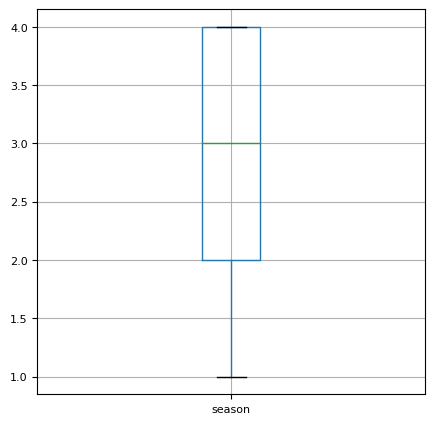

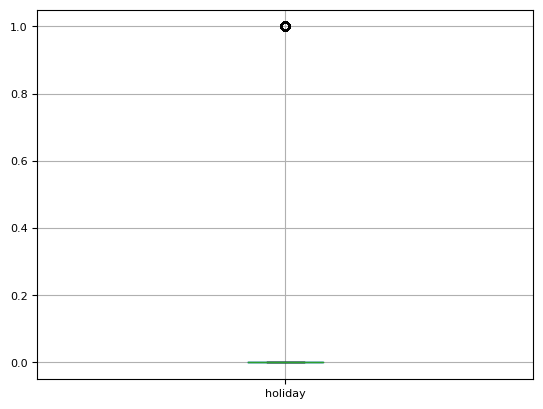

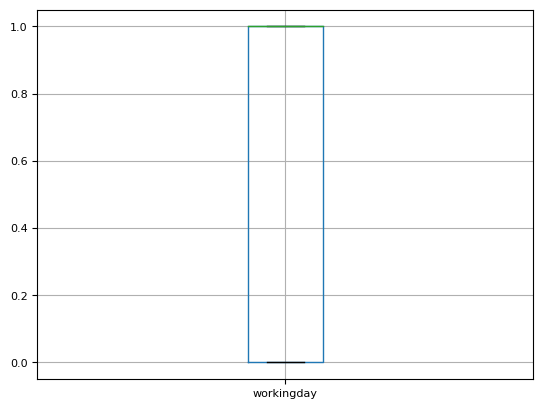

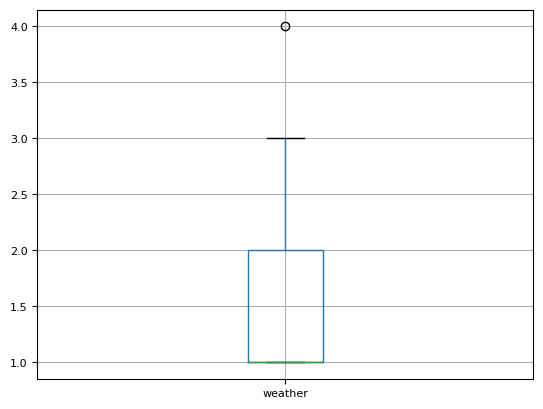

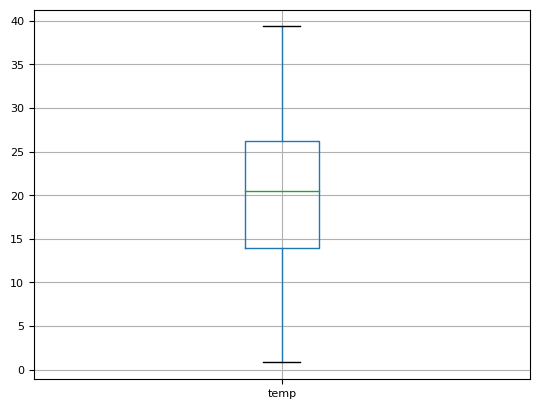

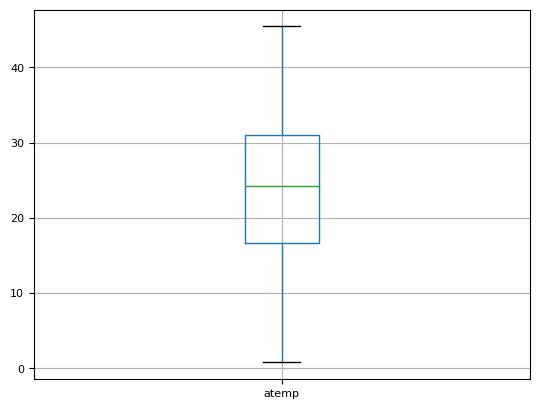

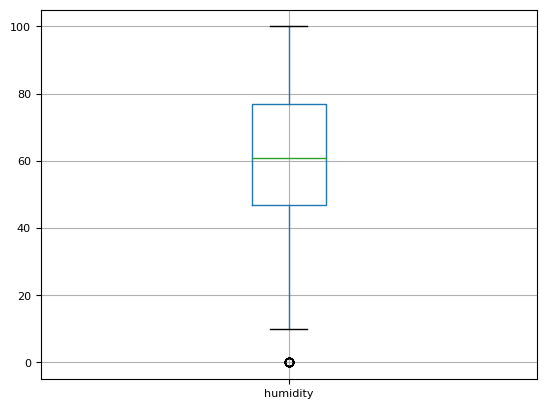

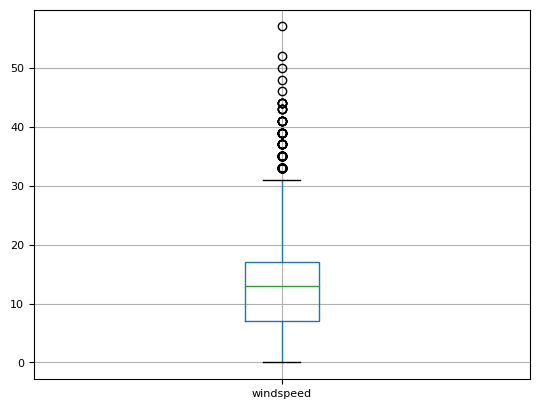

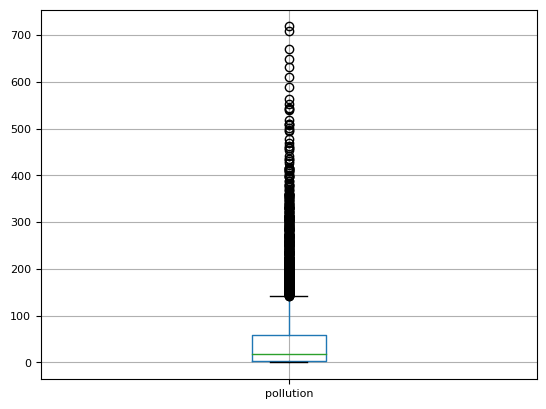

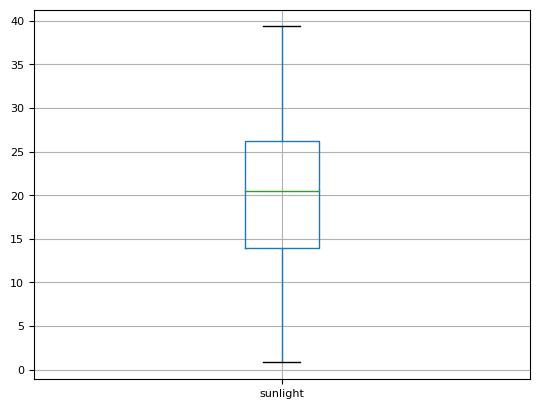

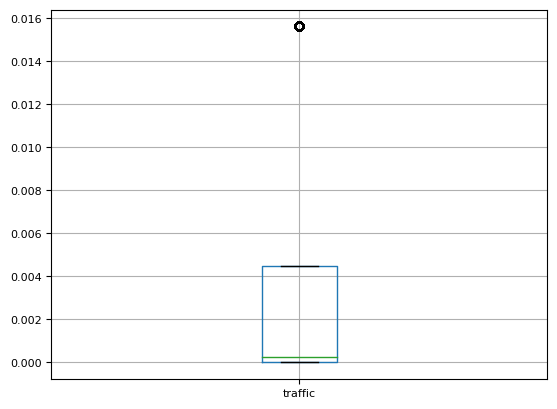

In [ ]:
#lets use some boxplots, we want to see outliers of our features.
plt.figure(figsize=(5,5))
dataNumeric = train_data.select_dtypes(include = [float,int]).columns.tolist()
for col in dataNumeric:
    train_data[[col]].boxplot()
    plt.show()

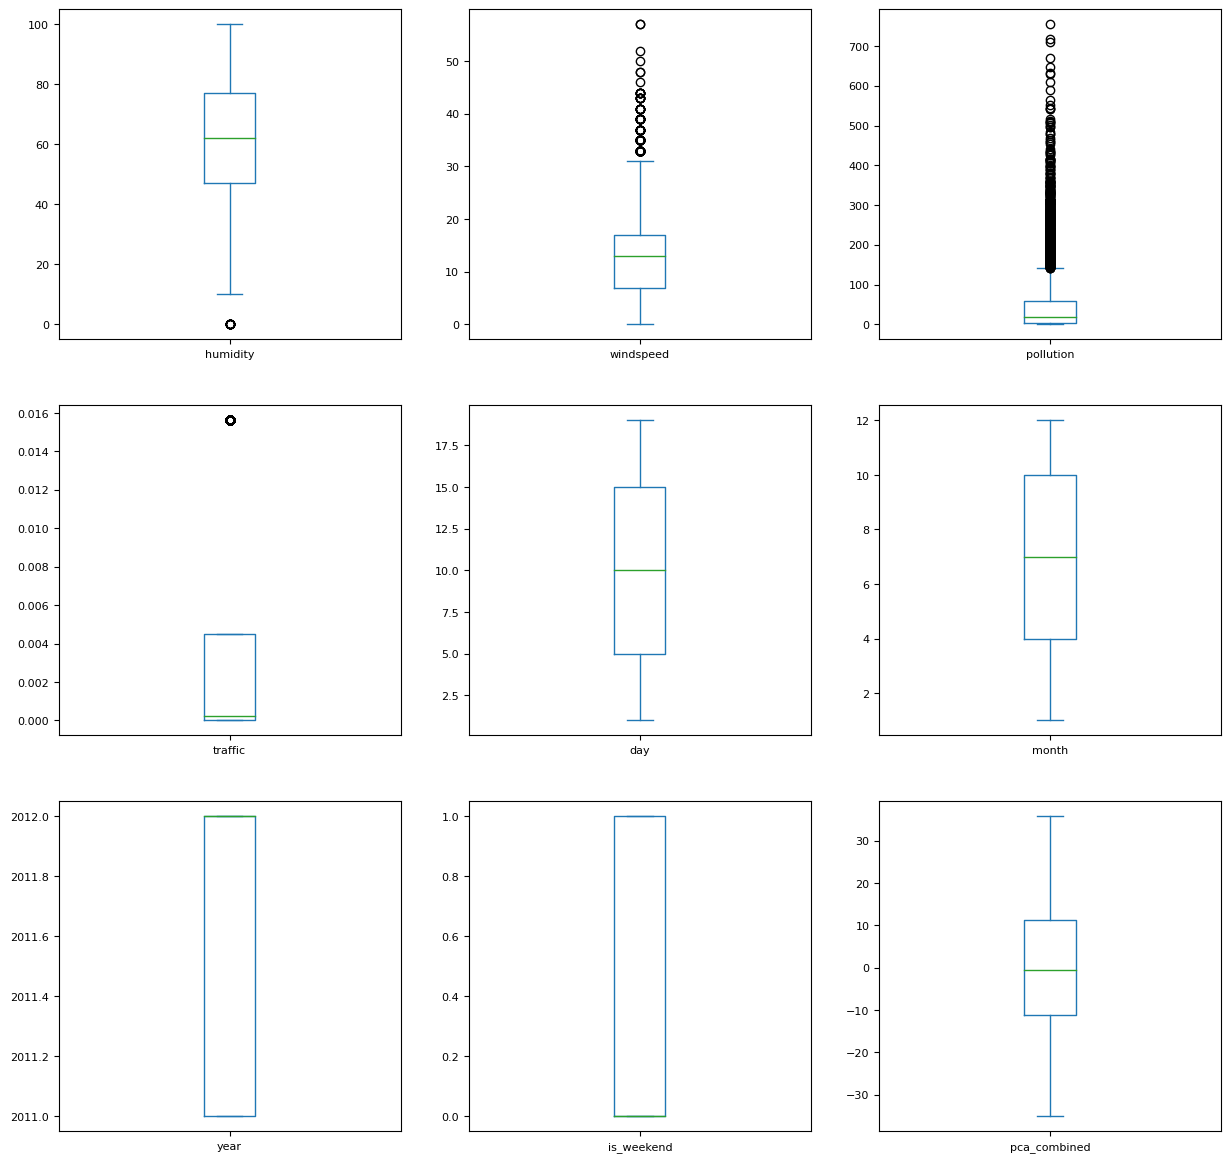

In [ ]:
train_data.plot(kind="box",subplots=True,layout=(6,3),figsize=(15,30));

TODO

But before getting to final conclusions, lets see the log-boxplots of these features:

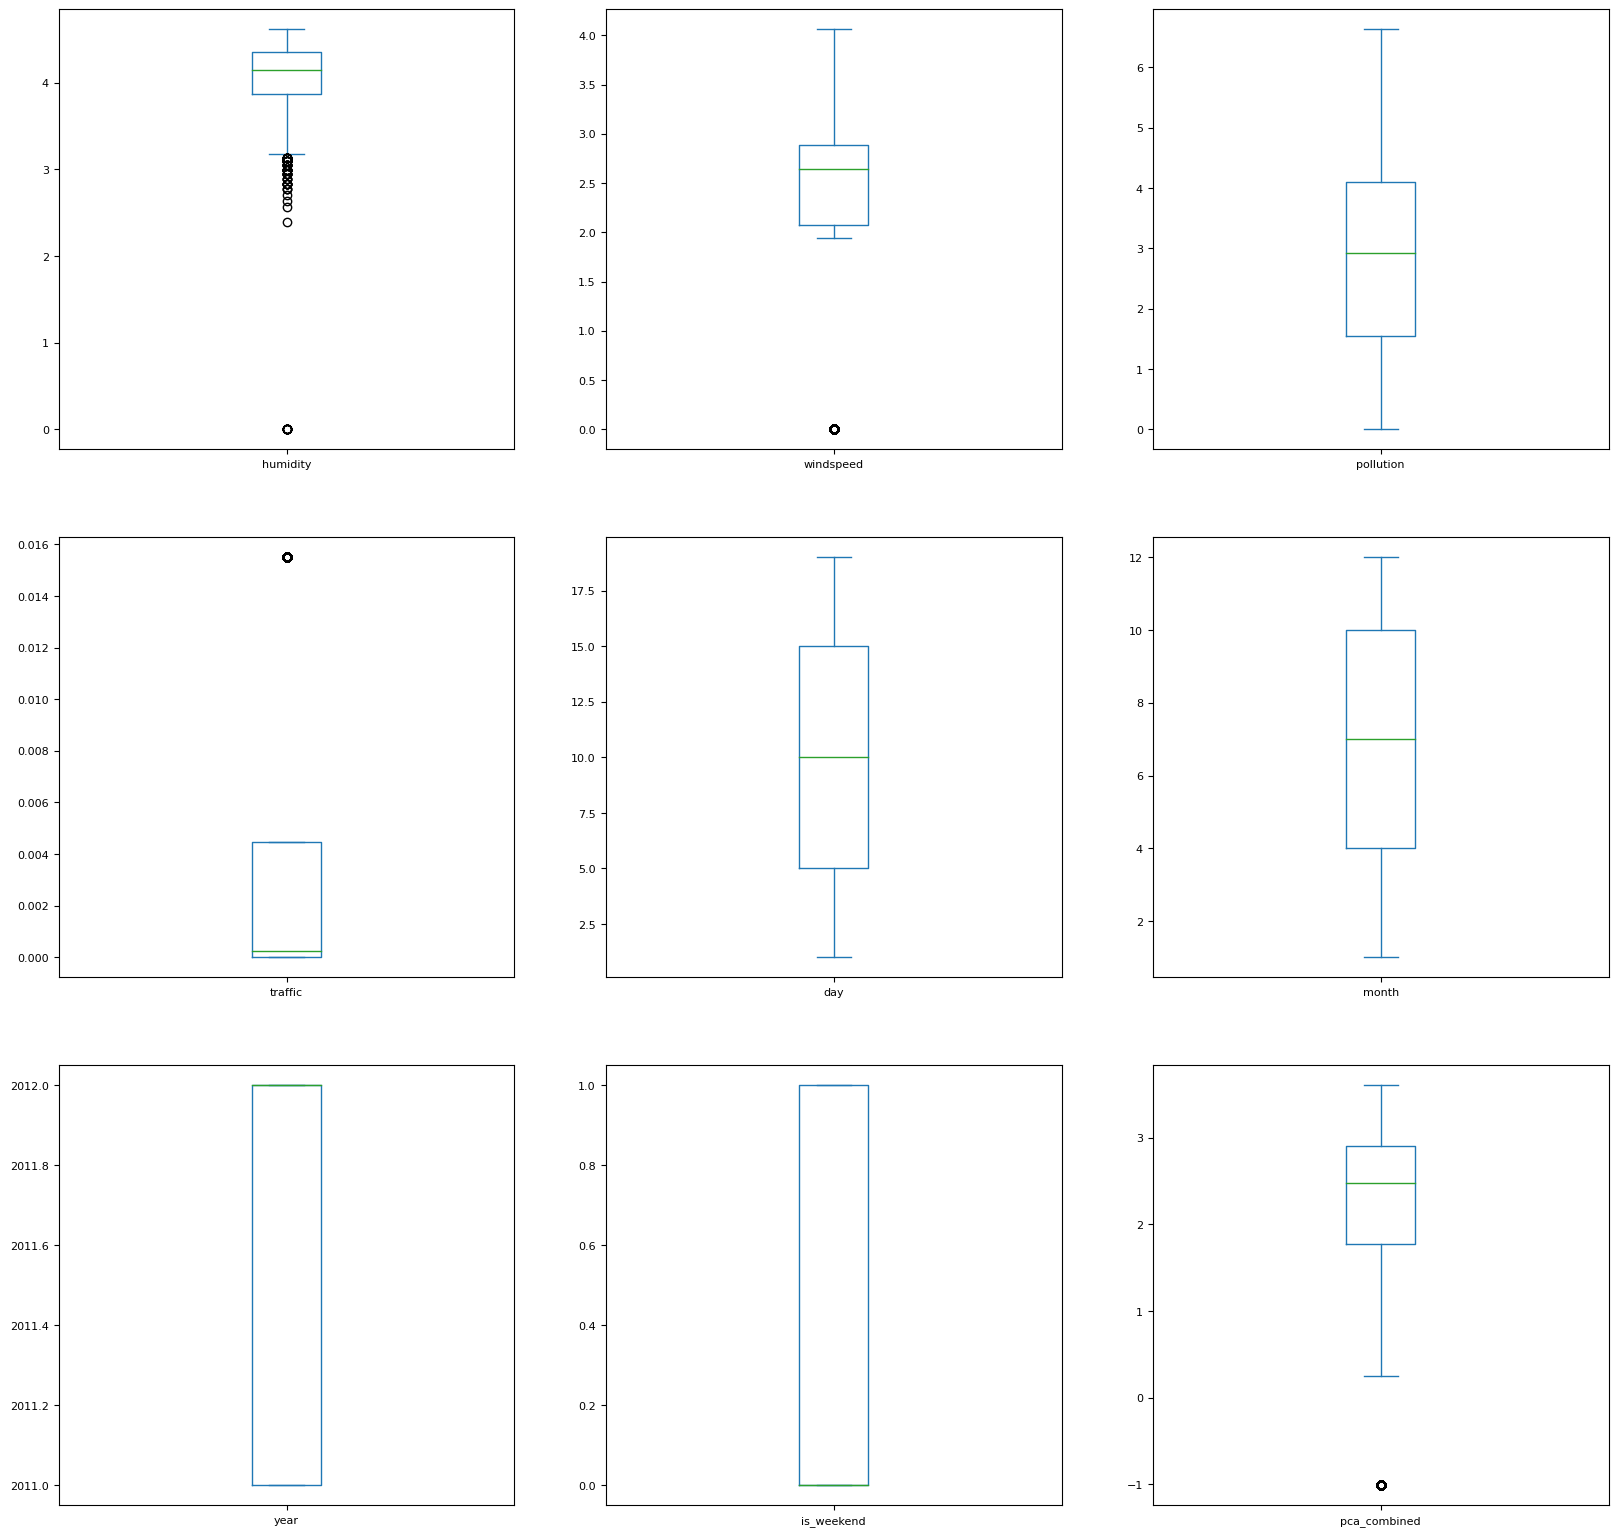

In [ ]:
# Identify float-type features
float_features = train_data.select_dtypes(include=[np.float64, np.float32])

# Apply logarithmic transformation to float features
log_train_data = float_features.apply(np.log1p)

# Combine the transformed features with non-float features
transformed_train_data = train_data.copy()
transformed_train_data[float_features.columns] = log_train_data

# Plot the boxplots with logarithmic values
transformed_train_data.plot(kind="box", subplots=True, layout=(6, 3), figsize=(20, 40))
plt.show()

TODO

Final check for normality just to be sure:

In [ ]:

# Determine the number of rows and columns for the grid
num_rows = 2  # Number of rows in the grid
num_cols = 2  # Number of columns in the grid

log_train_data = log_train_data[['size', 'vsize', 'numstrings', 'printables']] # TODO

# log_train_data1 = train_data[['size', 'vsize', 'numstrings', 'printables']]

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each column in log_train_data
for i, column in enumerate(log_train_data.columns):
    # Create Q-Q plot
    stats.probplot(log_train_data[column], dist="norm", plot=axes[i])

    # Set plot title
    axes[i].set_title(f"Q-Q Plot for {column}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


KeyError: "None of [Index(['size', 'vsize', 'numstrings', 'printables'], dtype='object')] are in the [columns]"

TODO

Creating functions to visualize outliers in several ways:

In [ ]:
def identify_bounds(df, feature, lower_percentile = 0.25, upper_percentile = 0.75, threshold=1.5):
    # Calculate the specified percentiles
    p1 = df[feature].quantile(lower_percentile)
    p2 = df[feature].quantile(upper_percentile)
    spread = p2 - p1

    # Define the upper and lower bounds
    lower_bound = p1 - threshold * spread
    upper_bound = p2 + threshold * spread

    # print(f"For {feature} the threshold given {threshold}, Lower Bound: '{lower_bound}', Upper Bound: '{upper_bound}'.")
    return lower_bound, upper_bound

In [ ]:
def visualize_outliers_histogram(df, feature, ax, lower_bound, upper_bound):
    # Plot histogram of the feature
    ax.hist(df[feature], bins=20)
    ax.set_title(f"Histogram of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

    # Mark the outliers on the plot
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    ax.scatter(outliers[feature], np.zeros_like(outliers[feature]), color='red', marker='x', label='Outliers')

    ax.legend()

def visualize_outliers_scatter(df, feature, ax, lower_bound, upper_bound):
    # Identify the outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

    # Visualize the outliers
    ax.scatter(df.index, df[feature], color='blue', label='Data')
    ax.scatter(outliers.index, outliers[feature], color='red', label='Outliers')
    ax.set_xlabel('Index')
    ax.set_ylabel(feature)
    ax.set_title(f'Outliers in {feature}')
    ax.legend()

def visualize_outliers_boxplot(df, feature, ax, lower_bound, upper_bound):
    # Create a boxplot of the feature
    sns.boxplot(data=df, y=feature, ax=ax, width=0.5)
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Values')
    ax.set_title(f'Boxplot of {feature}')


def plot_grid_outliers(df, features, plotting_funcs):
    num_cols = len(features)
    num_funcs = len(plotting_funcs)
    rows = num_cols
    cols = num_funcs

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 5 * rows))

    axes = axes.reshape(-1)  # Reshape axes to a 1D array

    for i, feature in enumerate(features):
        lower_bound, upper_bound = identify_bounds(df, feature)

        for j, plot_func in enumerate(plotting_funcs):

            ax = axes[i * num_funcs + j]  # Get the correct axis
            plot_func(df, feature, ax, lower_bound, upper_bound)

    fig.suptitle('Outlier view for the Normally Distributed Features\n\n', fontsize=16, wrap=True)
    # plt.figtext(0.5, 0.95, 'Outlier view for the Normally Distributed Features', ha='center', fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top spacing
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_normal_dist_outliers(IQR_data):

    IQR_features = ['size', 'vsize', 'numstrings', 'printables', 'A']
    plotting_funcs = [visualize_outliers_histogram, visualize_outliers_scatter, visualize_outliers_boxplot]
    plot_grid_outliers(IQR_data, IQR_features, plotting_funcs)

In each row we plot one of the normally distributed features and mark the outliers

In [ ]:
IQR_train_data = pd.concat([log_train_data, train_data['A']], axis=1)
plot_normal_dist_outliers(IQR_train_data)

In the preprocessing section we will handle these as decided.

Not forgetting about the other non-normally distributed, we will handle their outliers using Isolation Forest algorithm in the preprocessing section as well.

In [ ]:

# Count plots for categorical features
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='season', data=train_data)

plt.subplot(2, 2, 2)
sns.countplot(x='holiday', data=train_data)

plt.subplot(2, 2, 3)
sns.countplot(x='workingday', data=train_data)

plt.subplot(2, 2, 4)
sns.countplot(x='weather', data=train_data)

plt.show()

In [ ]:
train_data

In [ ]:
train_data.dtypes

In [ ]:
# Line plot for bike rentals over time
plt.figure(figsize=(16, 6))
plt.plot(train_with_labels['datetime'], train_with_labels['count'])
plt.title('Bike Rentals Over Time')
plt.xlabel('Datetime')
plt.ylabel('Count')
plt.show()

In [ ]:
train_data.info

## Preprocessing

In [ ]:
full_train_data_copy = full_train_data.copy()

labels = full_train_data_copy['count']
data = full_train_data_copy.drop('count', axis=1)

# Train split to train and validation with fixed random state (42) to ensure reproducibility
train_data, validation_data, train_labels, validation_labels = train_test_split(data, labels, test_size=0.2, random_state = 42, shuffle = True)

# Save copies in order to have a clean data set to use in the final preprocessing function
# (when pipelining all the functions from start to end)
train_data_ppc = train_data.copy()
train_lables_ppc = train_labels.copy()

validation_data_ppc = validation_data.copy()
validation_labels_ppc = validation_labels.copy()

  ### Handling Missing Values


In [ ]:
# As we saw bwfore - There are no missing values in our data.


In [ ]:
#train_data, validation_data = handle_corr_missing_values(train_data, validation_data) TODO

In [ ]:
# TODO - might be deleted ? - Not relevant for us
# Handle missing values function
#def handle_missing_values(train_data, test_data):
#    train_data, test_data = handle_corr_missing_values(train_data, test_data)
#    train_data, test_data = handle_rest_missing_values(train_data, test_data)
#    return train_data, test_data

### Add New Features

From the EDA we concluded that the best way to work with the 'datetime' feature is to seperate its values to new features.

In [ ]:
def datetime_feature_engineering(df):

  # Seperating 'datetime' to unique features
  df['day'] = df['datetime'].dt.day
  df['month'] = df['datetime'].dt.month
  df['year'] = df['datetime'].dt.year
  df['hour'] = df['datetime'].dt.hour
  df['is_weekend'] = df['datetime'].dt.dayofweek // 5

  # Remove the original 'datetime' feature
  df = df.drop('datetime', axis=1)

  return df

In [ ]:
train_data = datetime_feature_engineering(train_data)
validation_data = datetime_feature_engineering(validation_data)

In [ ]:
train_data.head()

In [ ]:
validation_data.head()

  ### Handling Categorial Features


In [ ]:
def handle_categorial_features(train_data, test_data):

    train_data, remaining_categories = reducing_category_types(train_data)
    test_data = apply_remaining_categories_for_test(test_data, remaining_categories)

    train_data = categorical_variables_spread(train_data)
    test_data = categorical_variables_spread(test_data)

    return train_data, test_data

In [ ]:
train_data, validation_data = handle_categorial_features(train_data, validation_data)

  ###  Outliers


Handeling the Outliers we found on the EDA step.

In [ ]:
def handle_outliers(train_data, train_labels, test_data):

    train_data, bounds = handle_ND_outliers_train(train_data)
    test_data = handle_ND_outliers_test(test_data, bounds)

    contamination = 0.001
    threshold = 0.001
    train_data, train_labels = handle_NND_outliers_train(train_data, train_labels, threshold, contamination)

    return train_data, train_labels, test_data

In [ ]:
train_data, train_labels, validation_data = handle_outliers(train_data, train_labels, validation_data)


NameError: name 'handle_ND_outliers_train' is not defined

  ### Large Dimensionality


##### `How will we recognize that the dimensions of the problem are too large?`

In order to assess as the dimensionality of the problem to a higher degree we can use the following steps:<br>

- Compute the Feature-to-Sample Ratio: Calculate the ratio of the number of features to the number of samples. If this ratio is significantly large, it might indicate a high-dimensional problem.

- Explore Feature Sparsity: Analyze the sparsity of our features. If a significant number of features have a high percentage of zero or near-zero values, it may indicate a high-dimensional problem.

- Assess Feature Redundancy: Determine the level of redundancy among the features. Redundant features provide similar or redundant information, which can increase dimensionality without adding valuable insights. (correlated features removal)

- Consider Feature Importance: Evaluate the importance or relevance of each feature in relation to the target variable (if available).

- Assess Computational Complexity: Take into account the computational resources and time required to handle high-dimensional data. Some algorithms may become computationally expensive or impractical to run with a large number of features.

- Evaluate Model Performance: Train and evaluate models using different subsets of features to assess their impact on model performance. If the performance remains consistent despite reducing the number of features, it may indicate high dimensionality.

  ### Data Normalizing


In [ ]:
def normalize_data(train_data, test_data):

    selected_features = ['size', 'vsize', 'numstrings', 'printables', 'A','imports', 'exports', 'symbols', 'paths', 'urls', 'registry', 'MZ', 'avlength', 'proportion_imports', 'file_type_prob_trid', 'B']

    train_data, scaler = normalize_data_train(train_data, selected_features)
    test_data = normalize_data_test(test_data, scaler, selected_features)

    return train_data, test_data

In [ ]:
train_data, validation_data = normalize_data(train_data, validation_data)

  ### Dimensionality Reduction

In [ ]:
def remove_features(data):
    features_to_remove = ['registry', 'size', 'MZ']
    data_selected = data.drop(features_to_remove, axis=1)
    return data_selected

In [ ]:
train_data = remove_features(train_data)
validation_data = remove_features(validation_data)

### Final Preprocessing Function

Now, after deciding what manipulations we will do on the train data (Outliers removal, Normalization, Missing values handling, Categorial data handling, Feature selection and Feature manipulation), we will create a generic preprocess function to run it all at once.

In [ ]:
def preprocess_data_ALL(train_data, train_labels, test_data):

    # Missing Values Handling
    train_data, test_data = handle_missing_values(train_data, test_data)

    # Add feature - 'proportion_imports'
    train_data = adding_new_feature(train_data)
    test_data = adding_new_feature(test_data)

    # Categorical Data Handling
    train_data, test_data = handle_categorial_features(train_data, test_data)

    # Outliers Removal
    train_data, train_labels, test_data = handle_outliers(train_data, train_labels, test_data)

    # Normalization
    train_data, test_data = normalize_data(train_data, test_data)

    # Feature Reduction
    train_data = remove_features(train_data)
    test_data = remove_features(test_data)

    # PCA
    # train_data, test_data = perform_pca(train_data, test_data, 0.99)

    return train_data, train_labels, test_data

In [ ]:
# Applying all the preprocessing decisions at once from start to end
preprocessed_train_data, preprocessed_train_labels, preprocessed_validation_data = preprocess_data_ALL(train_data_ppc, train_lables_ppc, validation_data_ppc)
preprocessed_validation_labels = test_labels_ppc.copy()

## Modeling

In [ ]:
#Random Forest
df = train_data.copy()
valid_df = validation_data.copy()
df_labels = train_labels.copy()
valid__df_labels= validation_labels.copy()

# Converting 'datetime' Feature
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Drop the original 'datetime' column if needed
df = df.drop('datetime', axis=1)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

#rf_model = RandomForestRegressor()
#param_grid = {
#    'n_estimators': [50, 100, 150],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(df, df_labels)

#best_params = grid_search.best_params_
#print("Best Hyperparameters:", best_params)


#def run_random_forest(x_train, y_train):
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
tunedrf = GridSearchCV(estimator=rf,
                          param_grid={'max_features': ['auto'],
                                      'max_depth' : [None],
                                      'min_samples_leaf' : [1]},
                          scoring='neg_mean_squared_error',
                          cv=3,
                          verbose=3,
                          refit=True)
tuned_rf.fit(df, df_labels)


#XGBOOST

# from sklearn.ensemble import GradientBoostingRegressor
# model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# from statsmodels.tsa.arima.model import ARIMA
# model_arima = ARIMA(df['count'], order=(p, d, q)).fit()
# from fbprophet import Prophet
# model_prophet = Prophet()


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# model_lstm = Sequential([
#     LSTM(units=50, activation='relu', input_shape=(n_steps, n_features)),
#     Dense(units=1)
# ])


# #Building the GRADIENT BOOSTED Model on our dataset
# from sklearn.ensemble import GradientBoostingRegressor
# GB_model = GradientBoostingRegressor().fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=None, max_features=auto, min_samples_leaf=1;, score=-3630.639 total time=  28.3s
[CV 2/3] END max_depth=None, max_features=auto, min_samples_leaf=1;, score=-3613.561 total time=  28.1s
[CV 3/3] END max_depth=None, max_features=auto, min_samples_leaf=1;, score=-3737.656 total time=  28.9s


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_estimators=1000,
                                             random_state=42),
             param_grid={'max_depth': [None], 'max_features': ['auto'],
                         'min_samples_leaf': [1]},
             scoring='neg_mean_squared_error', verbose=3)

Now that we have the data, we can proceed to train a model. Given a set of features, our goal is to predict a real number - the value of the property. In other words, this is a regression probelm so we'll only consider regression algorithms. In today's examples we'll compare linear regression and random forest.

We'll create a dictionary to save the models:

In [ ]:
models = {'Random forest': None}

### Random forest
Let's setup a function that trains a random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

We'll use RandomizedSearchCV to find the best number of trees for our RF:

In [ ]:
def run_random_forest(x_train, y_train):
  rf = RandomForestRegressor(n_estimators=200, random_state=42)
  tuned_rf = GridSearchCV(estimator=rf,
                          param_grid={'max_features': ['auto', 'sqrt', 'log2', 1/3]},
                          scoring='neg_mean_squared_error',
                          cv=3,
                          verbose=3,
                          refit=True)
  tuned_rf.fit(x_train, y_train)
  return tuned_rf

### Run all models

Let's run all models:

In [ ]:
def run_all_models(x, y):
  models_dict = {}
  models_dict['Random forest'] = run_random_forest(x, y)
  # models_dict['Decision tree'] = run_decision_tree(x, y)
  # models_dict['Linear regression'] = run_linear_regression(x, y)
  # models_dict['Ridge regression'] = run_ridge_regression(x, y)
  return models_dict

In [ ]:
models = run_all_models(train_data, train_labels.values.ravel())

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...................max_features=auto;, score=nan total time=   0.0s
[CV 2/3] END ...................max_features=auto;, score=nan total time=   0.0s
[CV 3/3] END ...................max_features=auto;, score=nan total time=   0.0s
[CV 1/3] END ...................max_features=sqrt;, score=nan total time=   0.0s
[CV 2/3] END ...................max_features=sqrt;, score=nan total time=   0.0s
[CV 3/3] END ...................max_features=sqrt;, score=nan total time=   0.0s
[CV 1/3] END ...................max_features=log2;, score=nan total time=   0.0s
[CV 2/3] END ...................max_features=log2;, score=nan total time=   0.0s
[CV 3/3] END ...................max_features=log2;, score=nan total time=   0.0s
[CV 1/3] END .....max_features=0.3333333333333333;, score=nan total time=   0.0s
[CV 2/3] END .....max_features=0.3333333333333333;, score=nan total time=   0.0s
[CV 3/3] END .....max_features=0.3333333333333333

ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '2012-10-07 12:00:00'

--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '2011-07-11 00:00:00'


In [ ]:
models

Comparing their cross validation scores:

In [ ]:
cv_scores = {}
cv_scores['Random forest'] = models['Random forest'].best_score_
cv_scores['Decision tree'] = models['Decision tree'].best_score_
cv_scores['Ridge regression'] = models['Ridge regression'].best_score_
cv_scores['Linear regression'] = models['Linear regression'][1].mean()
cv_scores

In [ ]:
sns.set()
cv_scores_df = -pd.DataFrame.from_dict(cv_scores, orient='index')
cv_scores_df.plot.bar(rot=45, legend=False)

In [ ]:
models['Random forest'].best_params_

## Evaluation of the Models

## Prediction



1.   List item
2.   List item



## *Output*

צריך למלא את זה לפי מה שיצא לנו!!!


In [ ]:
import pandas as pd
# Keep keys the same, and replace values according to your results and the specified type

results = {'model': ['string1', 'string2', 'string3'],
           'Score (RMSE)': ['string1', 'string2', 'string3'],
           'Hyperparams used': [['list1'], ['list2'], ['list3']],
           'Features dropped': [['list1'], ['list2'], ['list3']],
           'New features created': [['list1'], ['list2'], ['list3']],
           'Runtime trainining + inference (seconds)': ['int1', 'int2', 'int3'],
           'Hardware used (GPU/CPU/TPU)': ['string1', 'string2', 'string3'],
           'Explainability (top 3 features)': [['list1'], ['list2'], ['list3']]
           }

df = pd.DataFrame(results)
df

In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'example.csv'))

In [ ]:
#בדיקת המודל

import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))